# Predicting Salaries of MLB Players

- We found a dataset on kaggle.com of MLB position player statistics and salary data (adjusted for inflation) for 1985-2016. (https://www.kaggle.com/datasets/andrewdecker/hitters-salary-adjusted-to-inflation)

- The dataset comprises **15023 observations with 29 features (4 ID features, 2 salary features, 4 fielding features, 19 offensive features)**. 

- We focused on **ADJ Salary** (salary column adjusted for inflation) as our dependent variable.

- After cleaning the dataset, we had **15014 observations, 25 independent variables, 1 dependent variable**.

- Based on a suggestion in a Moneyball-themed post on Medium.com, we transformed the ADJ Salary column into its natural logarithm, thereby making the histogram distribution look more like a normal, Gaussian distribution. (https://medium.com/towards-data-science/did-the-money-follow-the-ball-analyzing-the-importance-of-baseball-batting-statistics-pre-144d7d452e1f)

- Correlation matrix analysis revealed that the offensive features were more highly correlated with our dependent variable than any of the other features in the dataset, so we focused our efforts there. **GS (games started), BB (walks), RBI (runs batted in), R (runs scored), HR (home runs), and InnOuts (inning outs, a measure of game time played)** were the highest-correlated with ADJ Salary. 

- A pairplot of these offensive features didn't show an obvious linear relationship with ADJ Salary, but unfortunately quite a bit of collinearity with each other.  

- Scatter plots between each feature of interest (GS, BB, RBI, R, HR, InnOuts) and the ADJ Salary dependent variable didn't reveal any obvious linear relationship.

- Simple univariate linear regression was conducted using LinearRegression(), GradientBoostingRegressor(), RandomForestRegressor(), and statsmodels ols regressor for each feature of interest. The regressors were unable to explain more than **20% of the variance in the dependent variable**. 

- Our next step was to attempt a multivariate linear regression with all of the features of interest, using the aforementioned regressors. This time the results were marginally better: the multivariate linear regressions explain approximately **19-26% of variance in ADJ Salary**.  

- We were disappointed with these results, so we took a different approach. What if we aggregated the dataset, and took the mean values of all of a player's stats over his career (including salary)? Could a multivariate linear regression on this aggregation perform any better?

- We grouped the dataset by playerID, took the mean of every feature, and ended up with **2468 observations**.

- Correlation analysis, pairplot visualization, and scatter plots now revealed stronger correlations and linear relationships between **RBI, R, twoB (doubles)** and ADJ Salary, but again with lots of multicollinearity. 

- Simple linear regressions for each new feature of interest and our dependent variable now showed over **50% explained variance**.

- Now a return to multivariate linear regression on these new features yielded similar values, achieving **59% explained variance** on the GradientBoostingRegressor() model. (GBR1 Testing Score: 	0.5907526209843459)

- We attempted to improve the scores using ensemble methods (Ridge and ElasticNet), but they did not improve upon the previous results. 

- Nevertheless, our methods demonstrated substantial improvement in explained variance in our dependent variable.  

In [1]:
# Import dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# EDA 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("Hitters_Adjusted_Salary.csv", index_col=0)
df

yearID   playerID    salary    ADJ Salary     GS  InnOuts   PO    A     E   DP teamID lgID    G   AB   R    H  2B  3B  HR   RBI    SB   CS  BB     SO  IBB  HBP   SH   SF  GIDP
0        1985  benedbr01    545000  1.310892e+06   67.0   1698.0  314   35   4.0    1    ATL   NL   70  208  12   42   6   0   0  20.0   0.0  1.0  22   12.0  1.0  1.0  4.0  2.0   8.0
1        1985  ceronri01    625000  1.503317e+06   76.0   2097.0  384   48   6.0    4    ATL   NL   96  282  15   61   9   0   3  25.0   0.0  3.0  29   25.0  1.0  1.0  0.0  4.0  15.0
2        1985  chambch01    800000  1.924245e+06   27.0    814.0  299   25   1.0   31    ATL   NL  101  170  16   40   7   0   3  21.0   0.0  0.0  18   22.0  4.0  0.0  0.0  1.0   5.0
3        1985  harpete01    250000  6.013267e+05  124.0   3299.0  215   10   5.0    0    ATL   NL  138  492  58  130  15   2  17  72.0   9.0  9.0  44   76.0  4.0  3.0  1.0  2.0  13.0
4        1985  hornebo01   1500000  3.607960e+06  125.0   3196.0  917  119  11.0  111    ATL   NL  130  483  61  129  25   3  27  89.0   1.0  1.0  50   57.0  4.0  1.0  0.0  6.0  18.0
...       ...        ...       ...           ...    ...      ...  ...  ...   ...  ...    ...  ...  ...  ...  ..  ...  ..  ..  ..   ...   ...  ...  ..    ...  ...  ...  ...  ...   ...
15018    2016  reverbe01   6250000  6.739673e+06   80.0   2141.0  170    2   2.0    1    WAS   NL  103  350  44   76   9   7   2  24.0  14.0  5.0  18   34.0  0.0  3.0  2.0  2.0  12.0
15019    2016  robincl01    534900  5.768082e+05   39.0   1071.0  285   12   2.0   30    WAS   NL  104  196  16   46   4   0   5  26.0   0.0  0.0  20   38.0  0.0  2.0  1.0  5.0   4.0
15020    2016  taylomi02    524000  5.650542e+05   48.0   1376.0  125    5   1.0    0    WAS   NL   76  221  28   51  11   0   7  16.0  14.0  3.0  14   77.0  0.0  1.0  0.0  1.0   2.0
15021    2016  werthja01  21733615  2.343639e+07  133.0   3474.0  201    5   1.0    1    WAS   NL  143  525  84  128  28   0  21  69.0   5.0  1.0  71  139.0  0.0  4.0  0.0  6.0  17.0
15022    2016  zimmery01  14000000  1.509687e+07  108.0   2907.0  852   44   4.0   88    WAS   NL  115  427  60   93  18   1  15  46.0   4.0  1.0  29  104.0  1.0  5.0  0.0  6.0  12.0

[15023 rows x 29 columns]

In [4]:
# Drop unnecessary columns

df = df.drop(columns=["salary", "teamID", "lgID"], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15023 entries, 0 to 15022
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      15023 non-null  int64  
 1   playerID    15023 non-null  object 
 2   ADJ Salary  15023 non-null  float64
 3   GS          15023 non-null  float64
 4   InnOuts     15023 non-null  float64
 5   PO          15023 non-null  int64  
 6   A           15023 non-null  int64  
 7   E           15023 non-null  float64
 8   DP          15023 non-null  int64  
 9   G           15023 non-null  int64  
 10  AB          15023 non-null  int64  
 11  R           15023 non-null  int64  
 12  H           15023 non-null  int64  
 13  2B          15023 non-null  int64  
 14  3B          15023 non-null  int64  
 15  HR          15023 non-null  int64  
 16  RBI         15023 non-null  float64
 17  SB          15023 non-null  float64
 18  CS          15023 non-null  float64
 19  BB          15023 non-nul

In [6]:
df.describe()

yearID    ADJ Salary            GS       InnOuts            PO             A             E            DP             G            AB             R             H            2B            3B            HR           RBI            SB            CS            BB           SO           IBB           HBP            SH            SF          GIDP
count  15023.000000  1.502300e+04  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000  15023.00000  15023.000000  15023.000000  15023.000000  15023.000000  15023.000000
mean    2000.659589  3.006733e+06     77.685549   2075.221327    253.296146     87.997471      5.739999     23.156627     91.254743    294.211609     40.282500     78.564534     15.200559      1.694335      8.879784     38.364974      5.832058      2.496039     29.179525     53.51967      2.476203      2.687280      1.846435      2.530720      6.733675
std        8.961125  4.436677e+06     48.686520   1269.713281    268.514557    123.753885      5.523810     33.211613     47.239321    191.304844     31.089787     56.047751     11.787423      2.233095      9.744188     31.343438      9.481292      3.233136     24.580754     38.10855      3.980006      3.334788      2.823960      2.484991      5.559373
min     1985.000000  0.000000e+00      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.00000      0.000000      0.000000      0.000000      0.000000      0.000000
25%     1993.000000  4.571930e+05     34.000000    939.000000     82.000000      5.000000      2.000000      1.000000     51.000000    125.000000     14.000000     29.000000      5.000000      0.000000      2.000000     13.000000      0.000000      0.000000     10.000000     23.00000      0.000000      0.000000      0.000000      1.000000      2.000000
50%     2000.000000  1.027027e+06     75.000000   2012.000000    178.000000     25.000000      4.000000      6.000000     95.000000    274.000000     34.000000     69.000000     13.000000      1.000000      5.000000     31.000000      2.000000      1.000000     23.000000     47.00000      1.000000      2.000000      1.000000      2.000000      6.000000
75%     2008.000000  3.728370e+06    122.000000   3229.000000    300.000000    118.000000      8.000000     32.000000    135.000000    465.000000     63.000000    124.000000     24.000000      2.000000     13.000000     58.000000      7.000000      4.000000     43.000000     78.00000      3.000000      4.000000      3.000000      4.000000     10.000000
max     2016.000000  3.981021e+07    163.000000   4388.000000   1597.000000    570.000000     42.000000    176.000000    163.000000    716.000000    152.000000    262.000000     59.000000     23.000000     73.000000    165.000000    110.000000     29.000000    232.000000    223.00000    120.000000     35.000000     39.000000     17.000000     35.000000

In [7]:
df.isna().sum()

yearID        0
playerID      0
ADJ Salary    0
GS            0
InnOuts       0
PO            0
A             0
E             0
DP            0
G             0
AB            0
R             0
H             0
2B            0
3B            0
HR            0
RBI           0
SB            0
CS            0
BB            0
SO            0
IBB           0
HBP           0
SH            0
SF            0
GIDP          0
dtype: int64

In [8]:
df.duplicated().sum()

8

In [9]:
df = df.drop_duplicates()

In [10]:
# Make ADJ Salary into integer

df["ADJ Salary"] = df["ADJ Salary"].astype("int").round()

In [11]:
# Drop any rows with 0 salary

df = df.loc[(df["ADJ Salary"] > 0), :]

In [12]:
df["ADJ Salary"].sort_values()

3681        19522
1424       136734
1560       136734
1559       136734
1545       136734
           ...   
12972    33817652
9765     34455125
12513    36818657
12055    39167750
11599    39810209
Name: ADJ Salary, Length: 15014, dtype: int32

In [13]:
df = df.loc[(df["ADJ Salary"] > 19522), :]

In [14]:
df["ADJ Salary"].sort_values()

1250       136734
1440       136734
1434       136734
1424       136734
1495       136734
           ...   
12972    33817652
9765     34455125
12513    36818657
12055    39167750
11599    39810209
Name: ADJ Salary, Length: 15013, dtype: int32

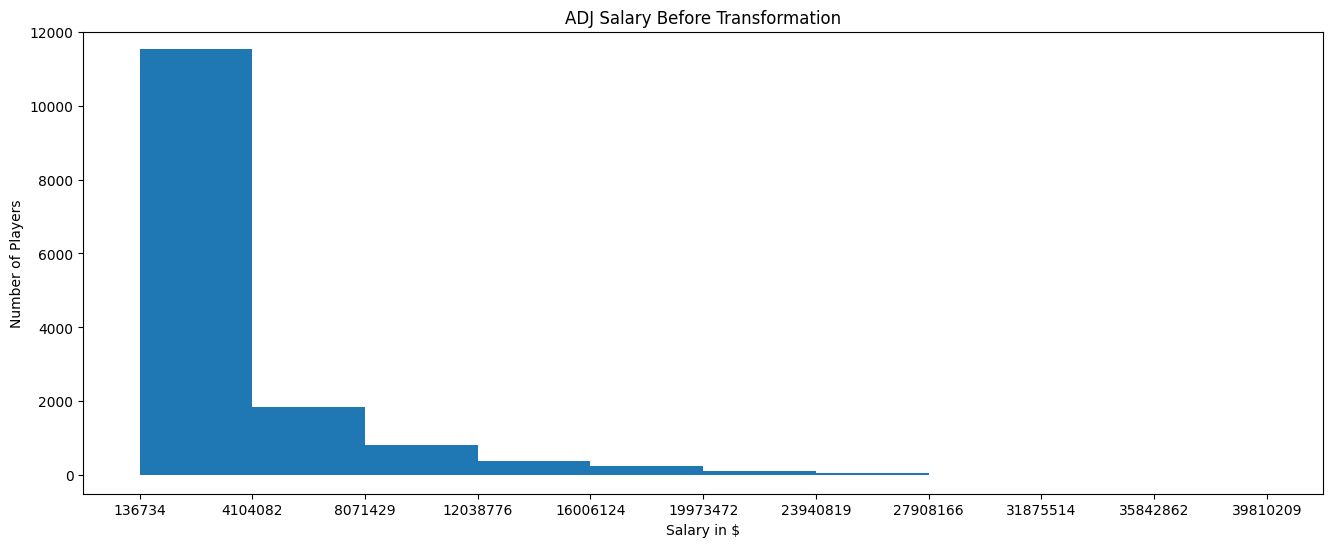

In [15]:
# plt.hist(df["ADJ Salary"])
# plt.show()

fig = plt.figure(figsize=(16,6))
n, bins, patches = plt.hist(df["ADJ Salary"])
plt.xticks(bins)
plt.ylim([-500, 12000])
plt.title("ADJ Salary Before Transformation")
plt.xlabel("Salary in $")
plt.ylabel("Number of Players")

plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.savefig('salary_no_log.png')

plt.show()


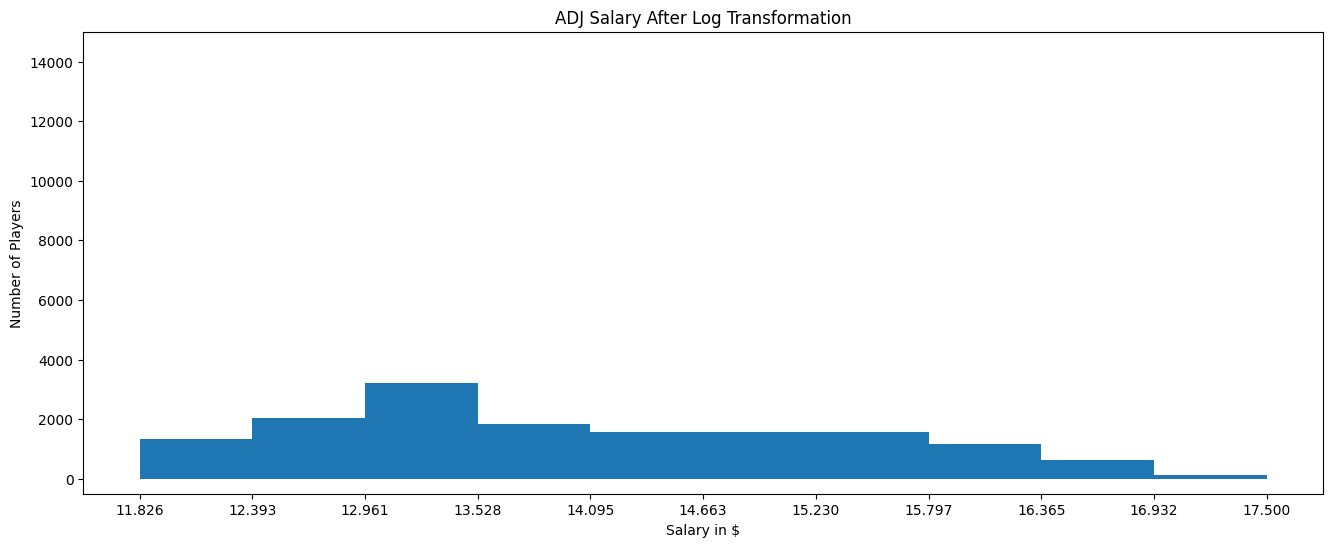

In [16]:
fig = plt.figure(figsize=(16,6))
n, bins, patches = plt.hist(np.log(df["ADJ Salary"]))
plt.xticks(bins)
plt.ylim([-500, 15000])
plt.title("ADJ Salary After Log Transformation")
plt.xlabel("Salary in $")
plt.ylabel("Number of Players")

plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.savefig('salary_log.png')
plt.show()

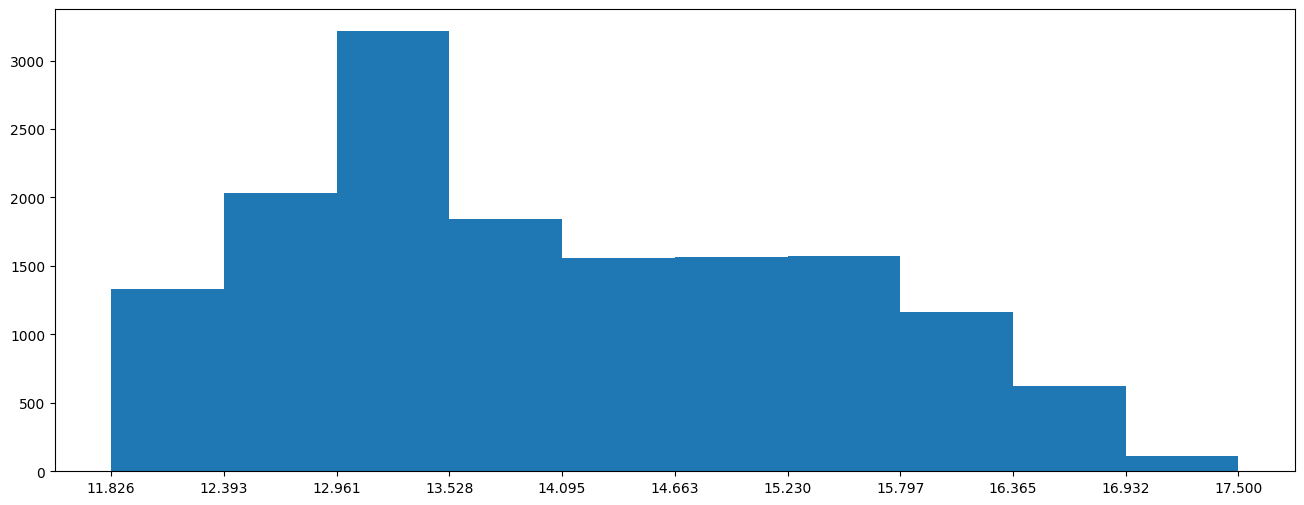

In [17]:
# plt.hist(np.log(df["ADJ Salary"]))
# plt.title("ADJ Salary After Log Transformation")
# plt.show()

fig = plt.figure(figsize=(16,6))
n, bins, patches = plt.hist(np.log(df["ADJ Salary"]))
plt.xticks(bins)
plt.ticklabel_format(style='plain')    # to prevent scientific notation.
plt.show()

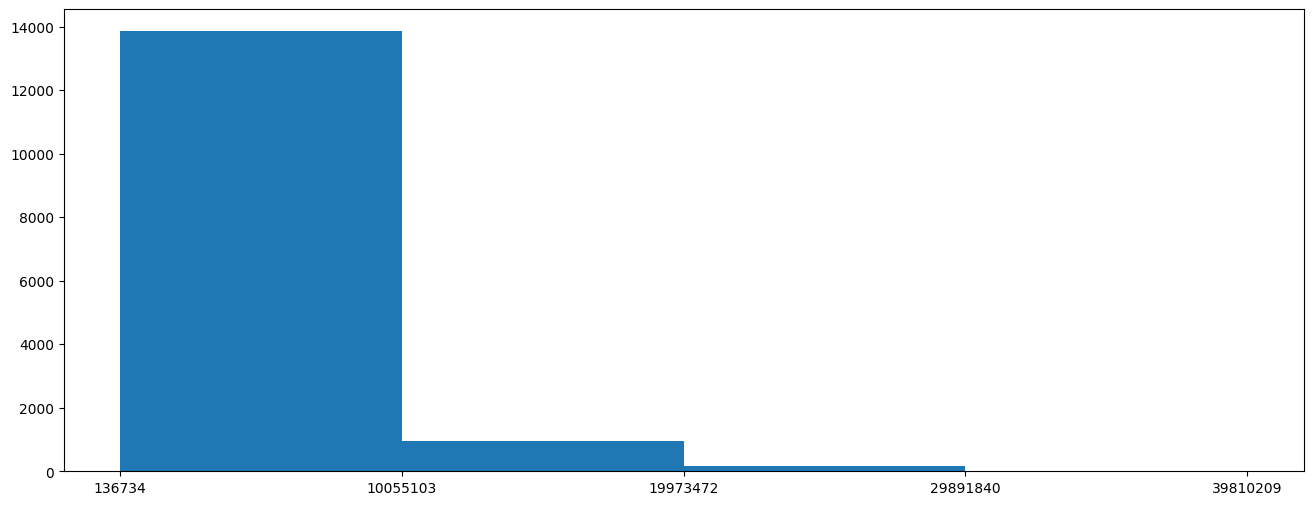

In [18]:
fig = plt.figure(figsize=(16,6))# 'auto', 'sturges', 'fd', 'doane', 'scott', 'rice' or 'sqrt'
n, bins, patches = plt.hist(df["ADJ Salary"], bins=4)
plt.xticks(bins)
plt.ticklabel_format(style='plain')    # to prevent scientific notation.

plt.show()

<AxesSubplot:xlabel='ADJ Salary'>

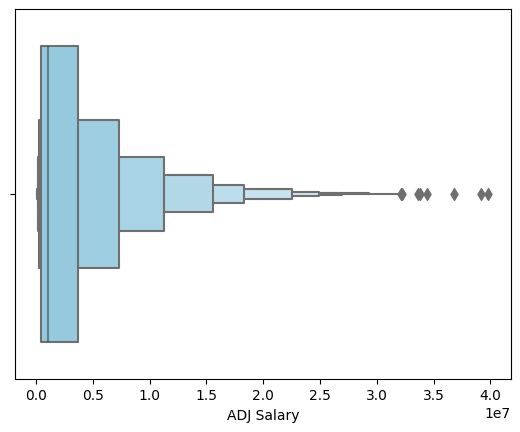

In [19]:
sns.boxenplot(x=df["ADJ Salary"], color='skyblue')

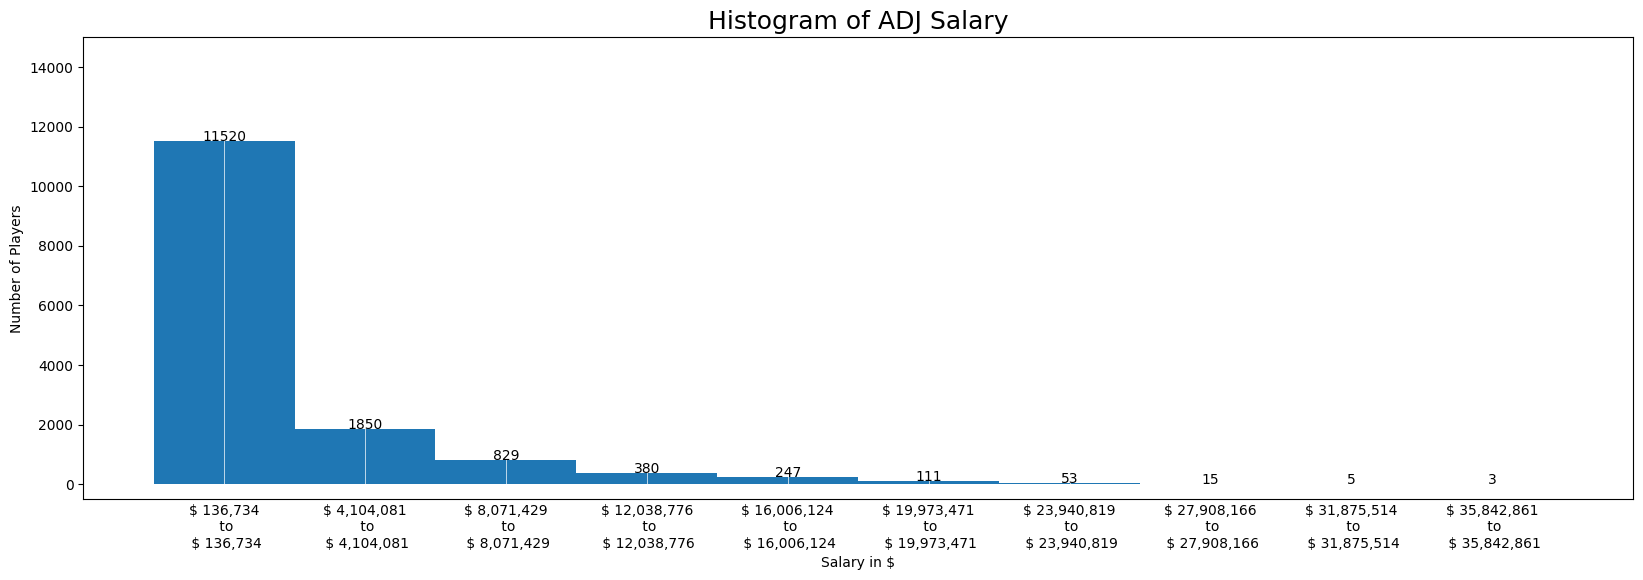

In [20]:
fig = plt.figure(figsize=(20,6))

n, bins, patches = plt.hist(df["ADJ Salary"])

plt.xticks(bins)
plt.ylim([-500, 15000])
plt.xlabel("Salary in $")
plt.ylabel("Number of Players")

plt.grid(color='white', lw = 0.5, axis='x')

plt.title('Histogram of ADJ Salary', loc = 'center', fontsize = 18)

plt.ticklabel_format(style='plain')    # to prevent scientific notation.

# x ticks

xticks = [(bins[idx+1] + value) / 2 for idx, value in enumerate(bins[:-1])]
xticks_labels = [ "$ {0:,}\n to\n $ {0:,}".format(int(value), bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels)
plt.tick_params(axis='x', which='both',length=0)


# plot values on top of bars
for idx, value in enumerate(n):
    if value > 0:
        plt.text(xticks[idx], value+5, round(int(value)), ha='center')
plt.show()

In [21]:
# Render the natural logarithm of the salary column

df["ADJ Salary"] = np.log(df["ADJ Salary"])

In [22]:
df = df.rename(columns={"2B":"twoB", "3B":"threeB"})

In [23]:
# 15014 observations, 25 independent variables, 1 dependent variable

df = df.drop_duplicates().reset_index(drop=True)
df

yearID   playerID  ADJ Salary     GS  InnOuts   PO    A     E   DP    G   AB   R    H  twoB  threeB  HR   RBI    SB   CS  BB     SO  IBB  HBP   SH   SF  GIDP
0        1985  benedbr01   14.086218   67.0   1698.0  314   35   4.0    1   70  208  12   42     6       0   0  20.0   0.0  1.0  22   12.0  1.0  1.0  4.0  2.0   8.0
1        1985  ceronri01   14.223184   76.0   2097.0  384   48   6.0    4   96  282  15   61     9       0   3  25.0   0.0  3.0  29   25.0  1.0  1.0  0.0  4.0  15.0
2        1985  chambch01   14.470044   27.0    814.0  299   25   1.0   31  101  170  16   40     7       0   3  21.0   0.0  0.0  18   22.0  4.0  0.0  0.0  1.0   5.0
3        1985  harpete01   13.306892  124.0   3299.0  215   10   5.0    0  138  492  58  130    15       2  17  72.0   9.0  9.0  44   76.0  4.0  3.0  1.0  2.0  13.0
4        1985  hornebo01   15.098653  125.0   3196.0  917  119  11.0  111  130  483  61  129    25       3  27  89.0   1.0  1.0  50   57.0  4.0  1.0  0.0  6.0  18.0
...       ...        ...         ...    ...      ...  ...  ...   ...  ...  ...  ...  ..  ...   ...     ...  ..   ...   ...  ...  ..    ...  ...  ...  ...  ...   ...
15008    2016  reverbe01   15.723522   80.0   2141.0  170    2   2.0    1  103  350  44   76     9       7   2  24.0  14.0  5.0  18   34.0  0.0  3.0  2.0  2.0  12.0
15009    2016  robincl01   13.265265   39.0   1071.0  285   12   2.0   30  104  196  16   46     4       0   5  26.0   0.0  0.0  20   38.0  0.0  2.0  1.0  5.0   4.0
15010    2016  taylomi02   13.244677   48.0   1376.0  125    5   1.0    0   76  221  28   51    11       0   7  16.0  14.0  3.0  14   77.0  0.0  1.0  0.0  1.0   2.0
15011    2016  werthja01   16.969801  133.0   3474.0  201    5   1.0    1  143  525  84  128    28       0  21  69.0   5.0  1.0  71  139.0  0.0  4.0  0.0  6.0  17.0
15012    2016  zimmery01   16.529998  108.0   2907.0  852   44   4.0   88  115  427  60   93    18       1  15  46.0   4.0  1.0  29  104.0  1.0  5.0  0.0  6.0  12.0

[15013 rows x 26 columns]

array([[<AxesSubplot:title={'center':'yearID'}>,
        <AxesSubplot:title={'center':'ADJ Salary'}>,
        <AxesSubplot:title={'center':'GS'}>,
        <AxesSubplot:title={'center':'InnOuts'}>,
        <AxesSubplot:title={'center':'PO'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'DP'}>,
        <AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'AB'}>],
       [<AxesSubplot:title={'center':'R'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'twoB'}>,
        <AxesSubplot:title={'center':'threeB'}>,
        <AxesSubplot:title={'center':'HR'}>],
       [<AxesSubplot:title={'center':'RBI'}>,
        <AxesSubplot:title={'center':'SB'}>,
        <AxesSubplot:title={'center':'CS'}>,
        <AxesSubplot:title={'center':'BB'}>,
        <AxesSubplot:title={'center':'SO'}>],
       [<AxesSubplot:title={'center':'IBB'}>,
        <AxesSubplot:title={'ce

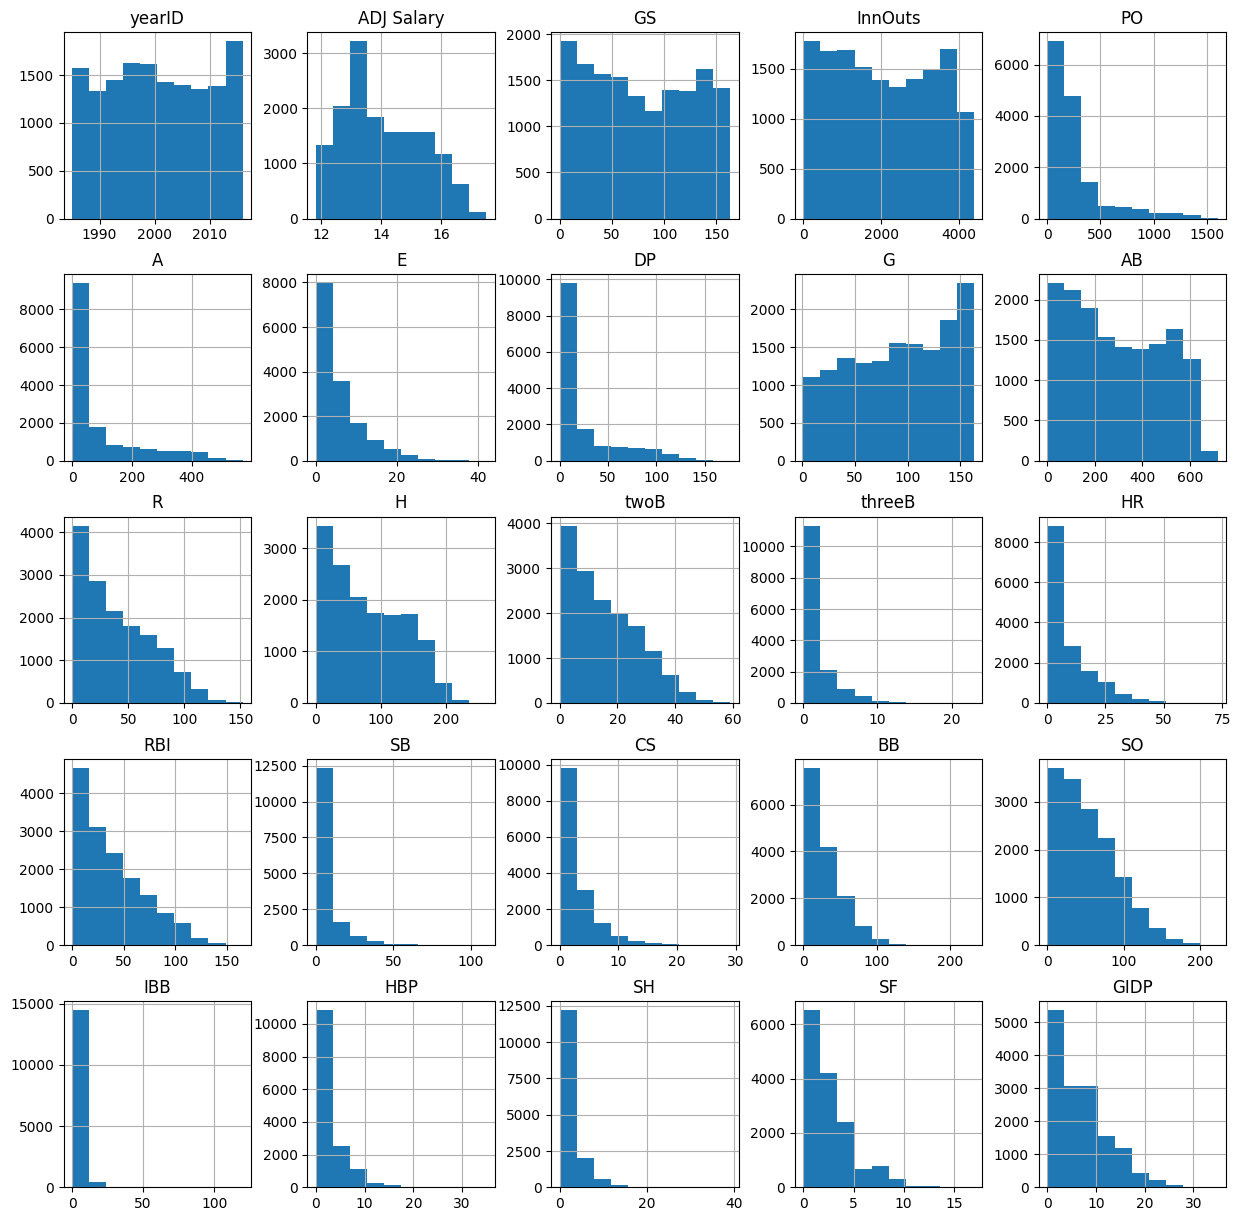

In [24]:
# Look at distributions of the variables

df.hist(figsize = (15, 15))  

In [25]:
# Correlation matrix reveals the best independent variables: RBI, BB, GS, R, HR 

cols = ["ADJ Salary","GS","InnOuts","PO","A","E","DP","G","AB","R",\
        "H","twoB","threeB","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]

corr = df[cols].corr()
corr = corr.style.background_gradient(cmap='Blues')
corr

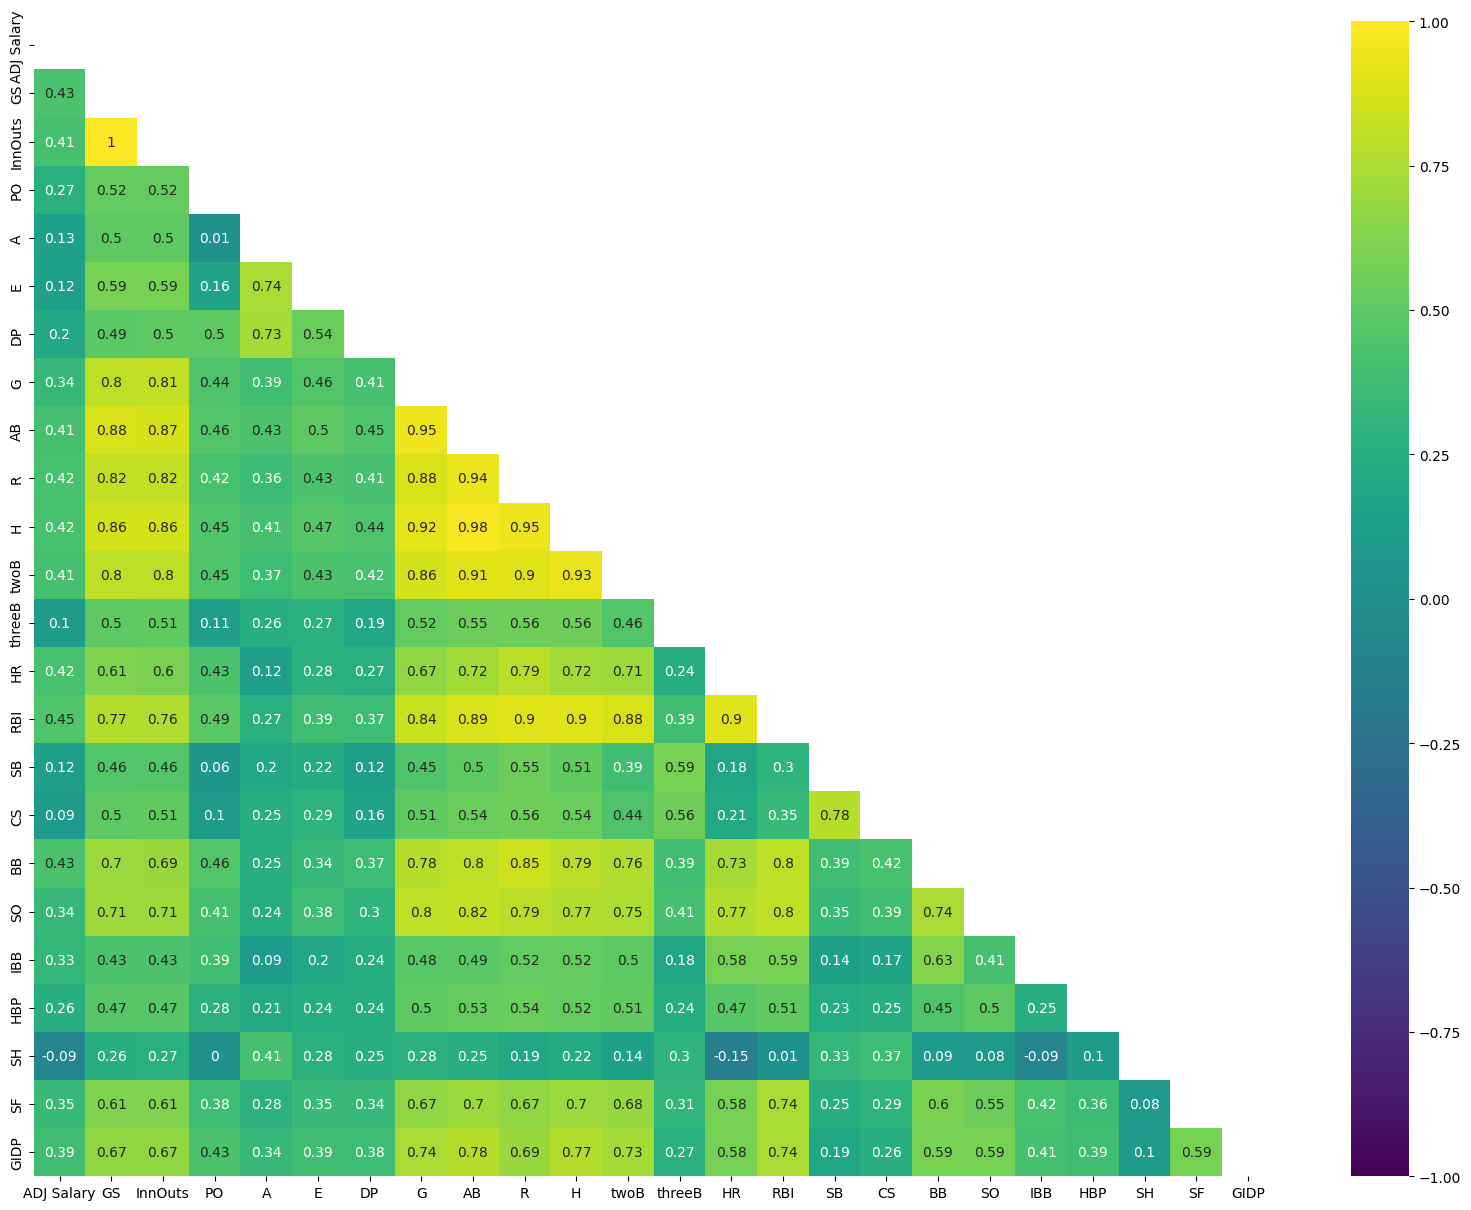

In [26]:
cols = ["ADJ Salary","GS","InnOuts","PO","A","E","DP","G","AB","R",\
        "H","twoB","threeB","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]

matrix = df[cols].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='viridis', mask=mask, ax=ax)
plt.savefig("df_correlation_matrix.png")
plt.show()

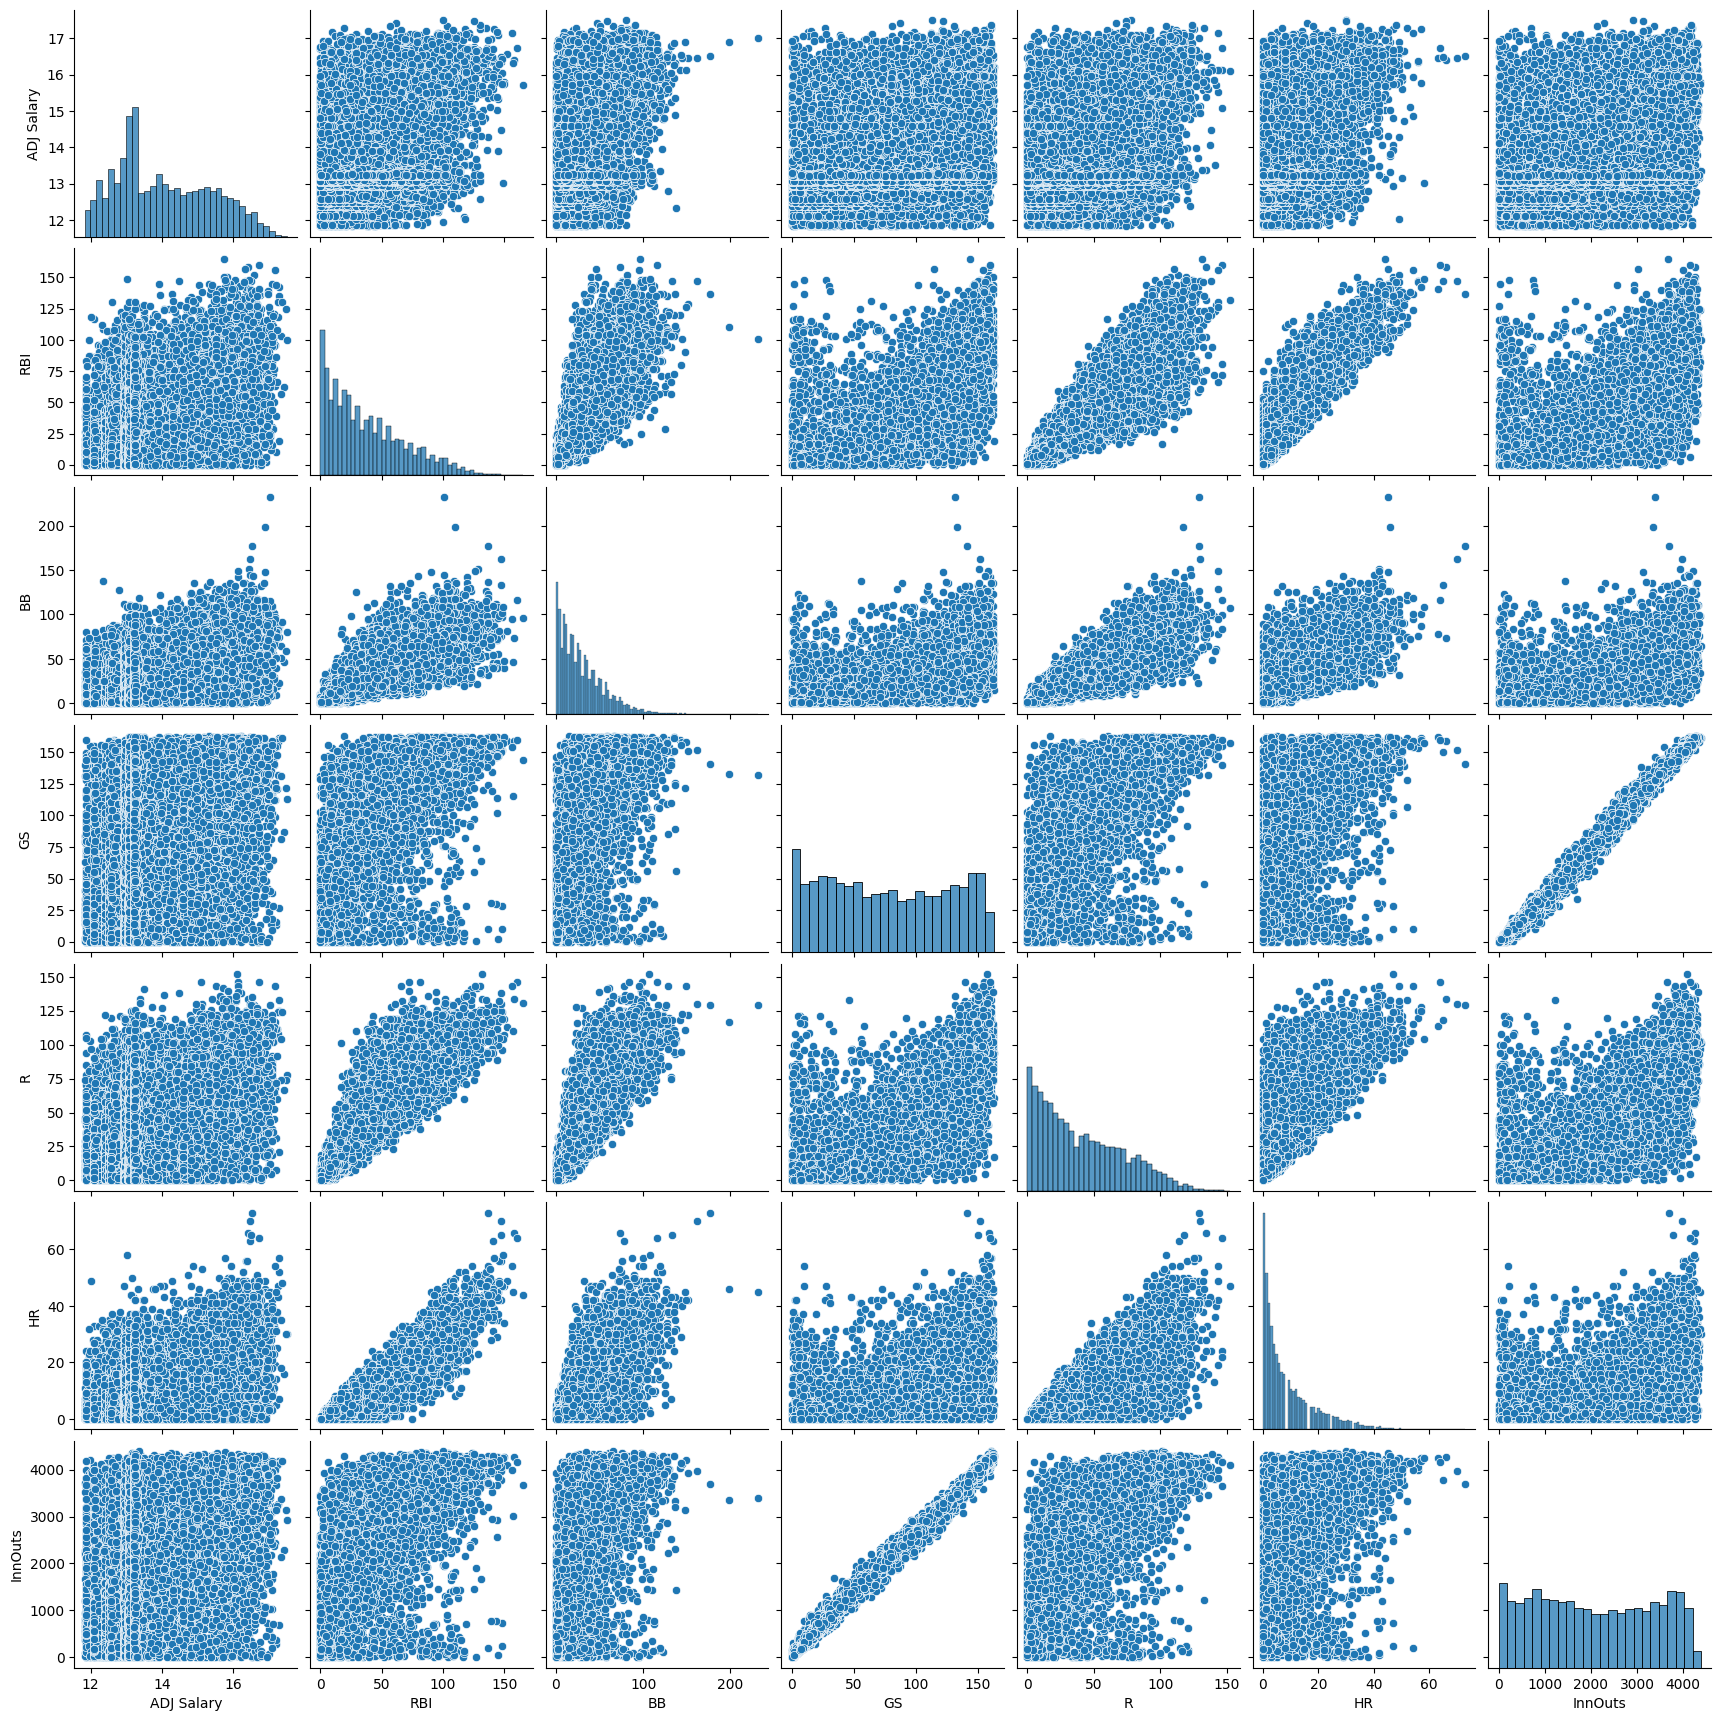

In [27]:
# Looking for multicollinearity

sns.pairplot(df[["ADJ Salary","RBI","BB","GS","R","HR","InnOuts"]])
plt.savefig("df_pairplot.png")
plt.show()

In [28]:
corr = df[["GS","BB","RBI","R","HR","InnOuts"]].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr
plt.show()

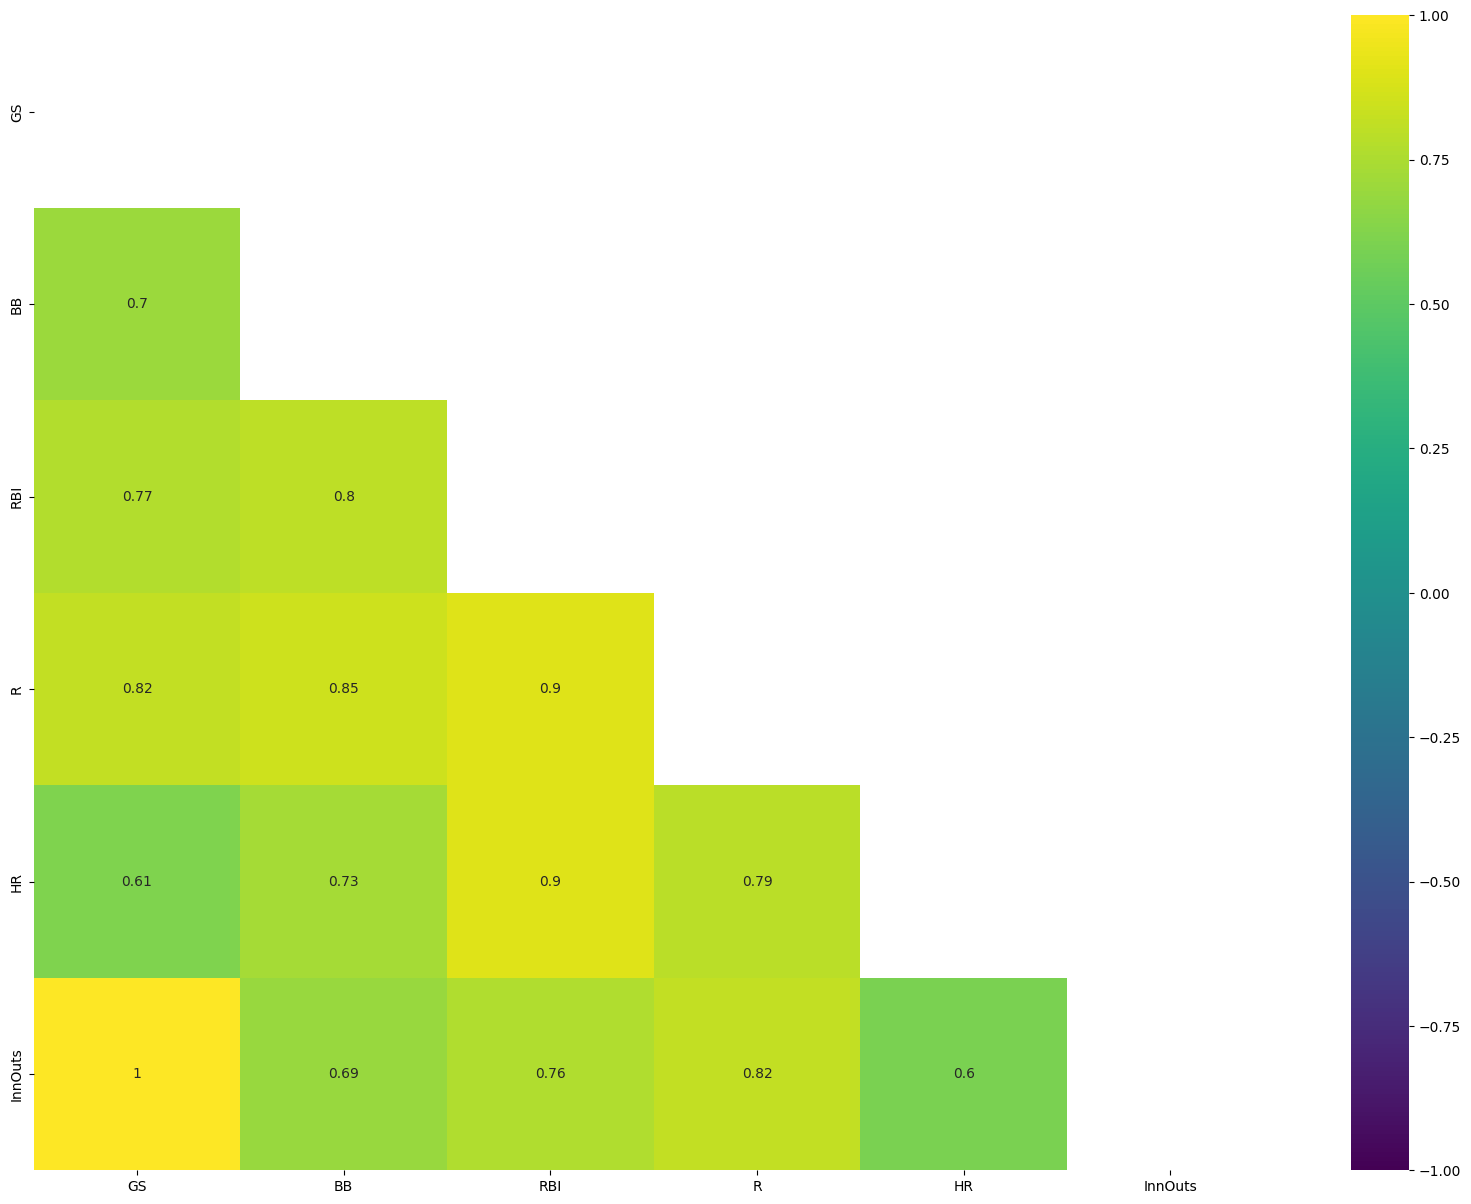

In [29]:
cols = ["GS","BB","RBI","R","HR","InnOuts"]

matrix = df[cols].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='viridis', mask=mask, ax=ax)
plt.savefig("best_vars_correlation_matrix.png")
plt.show()

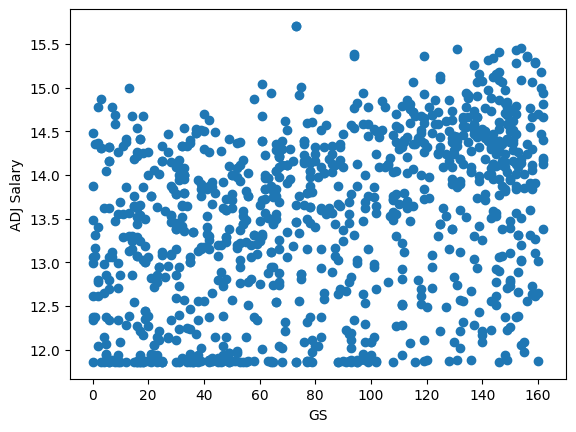

In [30]:
# Look at scatterplots

plt.scatter(df["GS"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("GS")
plt.ylabel("ADJ Salary")
plt.show()

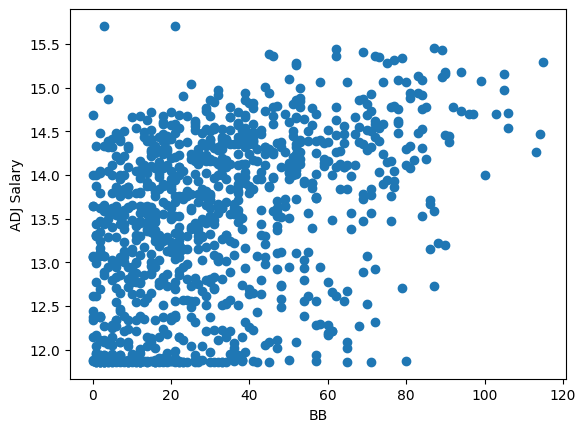

In [31]:
plt.scatter(df["BB"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("BB")
plt.ylabel("ADJ Salary")
plt.show()

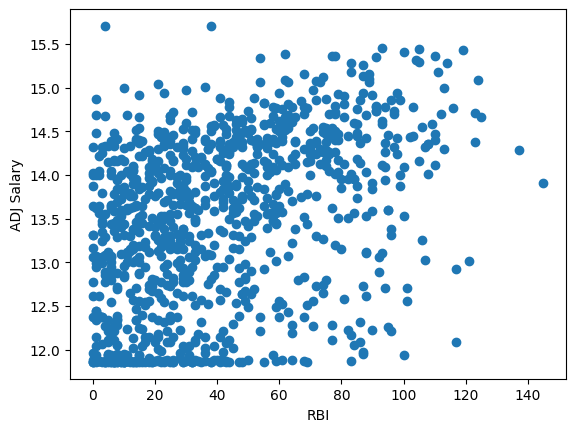

In [32]:
plt.scatter(df["RBI"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("RBI")
plt.ylabel("ADJ Salary")
plt.show()

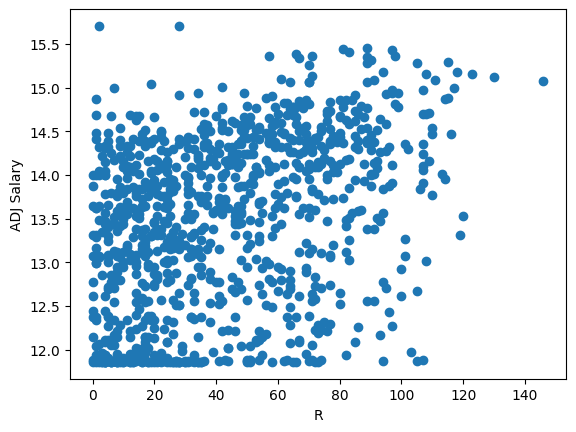

In [33]:
plt.scatter(df["R"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("R")
plt.ylabel("ADJ Salary")
plt.show()

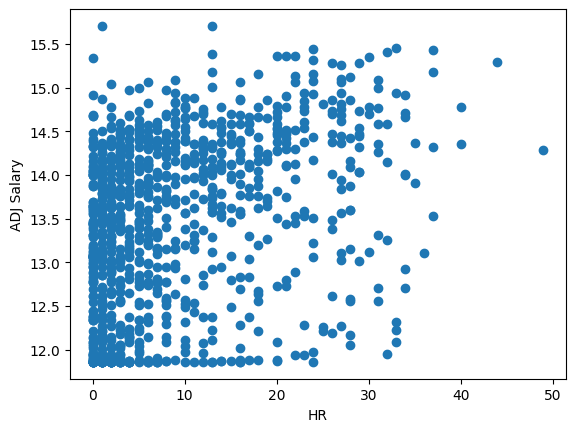

In [34]:
plt.scatter(df["HR"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("HR")
plt.ylabel("ADJ Salary")
plt.show()

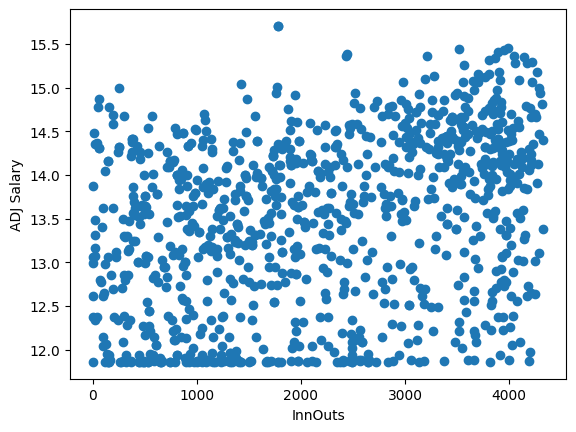

In [35]:
plt.scatter(df["InnOuts"][:1000], df["ADJ Salary"][:1000])
plt.xlabel("InnOuts")
plt.ylabel("ADJ Salary")
plt.show()

In [36]:
# Perform linear regression on each candidate independent variable

def simple_LR(a_df, col_list):
            
    # Assign X and y

    X = a_df[col_list]

    # X = df.drop(columns=["ADJ Salary", "playerID"])

    y = a_df["ADJ Salary"]

    # Split the data into X_train, X_test, y_train, y_test

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

    # Create a scaler to standardize the data

    scaler = StandardScaler()

    # Train the scaler with the X_train data.

    scaler.fit(X_train)

    # Transform X_train and X_test.

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    LR1 = LinearRegression().fit(X_train_scaled, y_train)
    GBR1 = GradientBoostingRegressor().fit(X_train_scaled, y_train)
    RFR1 = RandomForestRegressor().fit(X_train_scaled, y_train)

    LR1_pred = LR1.predict(X_test)
    GBR1_pred = GBR1.predict(X_test)
    RFR1_pred = RFR1.predict(X_test)

    LR1_mse = mean_squared_error(y_test, LR1_pred)
    GBR1_mse = mean_squared_error(y_test, GBR1_pred)
    RFR1_mse = mean_squared_error(y_test, RFR1_pred)

    LR1_r2 = r2_score(y_test, LR1_pred)
    GBR1_r2 = r2_score(y_test, GBR1_pred)
    RFR1_r2 = r2_score(y_test, RFR1_pred)

    # Score the regression models

    print(f"LR1 Training Score: \t\t{LR1.score(X_train_scaled, y_train)}")
    print(f"LR1 Testing Score: \t{LR1.score(X_test_scaled, y_test)}")
    print(f"LR1 r2: \t\t\t{LR1_r2}")
    print(f"LR1 mse: \t\t\t{LR1_mse}\n")

    print(f"GBR1 Training Score: \t\t{GBR1.score(X_train_scaled, y_train)}")
    print(f"GBR1 Testing Score: \t{GBR1.score(X_test_scaled, y_test)}")
    print(f"GBR1 r2: \t\t\t{GBR1_r2}")
    print(f"GBR1 mse: \t\t\t{GBR1_mse}\n")

    print(f"RFR1 Training Score: \t\t{RFR1.score(X_train_scaled, y_train)}")
    print(f"RFR1 Testing Score: \t{RFR1.score(X_test_scaled, y_test)}")
    print(f"RFR1 r2: \t\t\t{RFR1_r2}")
    print(f"RFR1 mse: \t\t\t{RFR1_mse}\n")

    formula = f'y ~ {" + ".join(c for c in col_list)}'

    LR1_stats = smf.ols(formula=formula, data=X).fit()

    print(LR1_stats.summary())

In [37]:
simple_LR(df, ["RBI"])

LR1 Training Score: 		0.19833103506548266
LR1 Testing Score: 	0.2115928666458784
LR1 r2: 			-483.93377878459756
LR1 mse: 			832.0408026485273

GBR1 Training Score: 		0.20715785302192224
GBR1 Testing Score: 	0.21145381931719187
GBR1 r2: 			-1.5207156258933647
GBR1 mse: 			4.324999297581651

RFR1 Training Score: 		0.20961666432214698
RFR1 Testing Score: 	0.20507392459844176
RFR1 r2: 			-2.123475048852725
RFR1 mse: 			5.3592032570171915

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     3792.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:34   Log-Likelihood:                -23716.
No. Observations:               15013   AIC:                         4.744e+04
Df Resid

In [38]:
simple_LR(df, ["GS"])

LR1 Training Score: 		0.1802038731034129
LR1 Testing Score: 	0.20001495022897375
LR1 r2: 			-1522.439036640259
LR1 mse: 			2613.889760389941

GBR1 Training Score: 		0.18814711428812803
GBR1 Testing Score: 	0.19729285749401093
GBR1 r2: 			-0.67733965803988
GBR1 mse: 			2.877949725192531

RFR1 Training Score: 		0.19257242270064345
RFR1 Testing Score: 	0.18927225135522618
RFR1 r2: 			-0.6079659740235706
RFR1 mse: 			2.7589195848787647

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     3412.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:35   Log-Likelihood:                -23869.
No. Observations:               15013   AIC:                         4.774e+04
Df Residua

In [39]:
simple_LR(df, ["BB"])

LR1 Training Score: 		0.1838904320502288
LR1 Testing Score: 	0.1946982742186617
LR1 r2: 			-265.48961139256744
LR1 mse: 			457.23816294318436

GBR1 Training Score: 		0.1957322409556136
GBR1 Testing Score: 	0.19789900734350319
GBR1 r2: 			-3.3204231259039005
GBR1 mse: 			7.412905602220584

RFR1 Training Score: 		0.1977314070156172
RFR1 Testing Score: 	0.19278131784928654
RFR1 r2: 			-3.3403385992942862
RFR1 mse: 			7.447076219302349

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     3444.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:37   Log-Likelihood:                -23856.
No. Observations:               15013   AIC:                         4.772e+04
Df Residua

In [40]:
simple_LR(df, ["R"])

LR1 Training Score: 		0.17582349701702327
LR1 Testing Score: 	0.19176378940449068
LR1 r2: 			-449.08989475400904
LR1 mse: 			772.2562825664961

GBR1 Training Score: 		0.185336291993481
GBR1 Testing Score: 	0.1919188177742207
GBR1 r2: 			-2.0090367644468317
GBR1 mse: 			5.162852072223577

RFR1 Training Score: 		0.18912364043495555
RFR1 Testing Score: 	0.18514987123737403
RFR1 r2: 			-2.0404273074561545
RFR1 mse: 			5.216711410846082

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     3292.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:39   Log-Likelihood:                -23919.
No. Observations:               15013   AIC:                         4.784e+04
Df Residua

In [41]:
simple_LR(df, ["HR"])

LR1 Training Score: 		0.1788686931031611
LR1 Testing Score: 	0.17181040173933915
LR1 r2: 			-28.722932548662456
LR1 mse: 			50.99808208213571

GBR1 Training Score: 		0.19203449394223282
GBR1 Testing Score: 	0.18361396109457062
GBR1 r2: 			-1.5996284837012107
GBR1 mse: 			4.460396583607573

RFR1 Training Score: 		0.19209862013817702
RFR1 Testing Score: 	0.18254691102188647
RFR1 r2: 			-1.599666467343472
RFR1 mse: 			4.460461755269307

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     3233.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:40   Log-Likelihood:                -23943.
No. Observations:               15013   AIC:                         4.789e+04
Df Residu

In [42]:
simple_LR(df, ["InnOuts"])

LR1 Training Score: 		0.16693632802244418
LR1 Testing Score: 	0.18752386637276197
LR1 r2: 			-1005317.4915447504
LR1 mse: 			1724907.6909403133

GBR1 Training Score: 		0.18838877039440727
GBR1 Testing Score: 	0.18502612476393343
GBR1 r2: 			-0.010642090051963926
GBR1 mse: 			1.734041827122829

RFR1 Training Score: 		0.4602610825962551
RFR1 Testing Score: 	-0.009190195662911682
RFR1 r2: 			0.0005506953347526045
RFR1 mse: 			1.7148374438761569

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     3121.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:44   Log-Likelihood:                -23989.
No. Observations:               15013   AIC:                         4.798e+04


In [43]:
df.to_csv("first_predictions_df.csv")

## Results:

- all the highly correlated independent vars are also correlated with each other = multicollinearity!

## First attempt at multivariate linear regression 

In [44]:
# Assign X and y

X = df[["RBI", "BB", "GS", "R", "HR"]]

y = df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

LR1 = LinearRegression().fit(X_train_scaled, y_train)
GBR1 = GradientBoostingRegressor().fit(X_train_scaled, y_train)
RFR1 = RandomForestRegressor().fit(X_train_scaled, y_train)

LR1_pred = LR1.predict(X_test)
GBR1_pred = GBR1.predict(X_test)
RFR1_pred = RFR1.predict(X_test)

LR1_mse = mean_squared_error(y_test, LR1_pred)
GBR1_mse = mean_squared_error(y_test, GBR1_pred)
RFR1_mse = mean_squared_error(y_test, RFR1_pred)

LR1_r2 = r2_score(y_test, LR1_pred)
GBR1_r2 = r2_score(y_test, GBR1_pred)
RFR1_r2 = r2_score(y_test, RFR1_pred)

# Score the regression models

print(f"LR1 Training Score: \t\t{LR1.score(X_train_scaled, y_train)}")
print(f"LR1 Testing Score: \t{LR1.score(X_test_scaled, y_test)}")
print(f"LR1 r2: \t\t\t{LR1_r2}")
print(f"LR1 mse: \t\t\t{LR1_mse}\n")

print(f"GBR1 Training Score: \t\t{GBR1.score(X_train_scaled, y_train)}")
print(f"GBR1 Testing Score: \t{GBR1.score(X_test_scaled, y_test)}")
print(f"GBR1 r2: \t\t\t{GBR1_r2}")
print(f"GBR1 mse: \t\t\t{GBR1_mse}\n")

print(f"RFR1 Training Score: \t\t{RFR1.score(X_train_scaled, y_train)}")
print(f"RFR1 Testing Score: \t{RFR1.score(X_test_scaled, y_test)}")
print(f"RFR1 r2: \t\t\t{RFR1_r2}")
print(f"RFR1 mse: \t\t\t{RFR1_mse}\n")


LR1_stats = smf.ols(formula = "y ~ RBI + BB + GS + R + HR", data=X).fit()

LR1_stats.summary()

LR1 Training Score: 		0.23416771209761933
LR1 Testing Score: 	0.24737190450134217
LR1 r2: 			-749.9750619475503
LR1 mse: 			1288.5097319430402

GBR1 Training Score: 		0.29759180531008045
GBR1 Testing Score: 	0.2619338519754699
GBR1 r2: 			-2.7958226439524543
GBR1 mse: 			6.512805371697008

RFR1 Training Score: 		0.8773352953924991
RFR1 Testing Score: 	0.19836435507965866
RFR1 r2: 			-1.605824162240475
RFR1 mse: 			4.471027019288258



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     935.9
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:25:52   Log-Likelihood:                -23370.
No. Observations:               15013   AIC:                         4.675e+04
Df Residuals:                   15007   BIC:                         4.680e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1379      0.018    737.843      0.000      13.103      13.173
RBI            0.0050      0.001      4.844      0.000       0.003       0.007
BB             0.0113      0.001     15.159      0.000       0.010       0.013
GS             0.0071      0.000     20.062      0.000       0.006       0.008
R             -0.0086      0.001     -9.711      0.000      -0.010      -0.007
HR             0.0214      0.002      9.059      0.000       0.017       0.026
==============================================================================
Omnibus:                      309.992   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.566
Skew:                           0.203   Prob(JB):                     6.34e-50
Kurtosis:                       2.555   Cond. No.                         228.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results: 
- the multivariate linear regressions explain approximately 19-26% of variance
- we can do better!

## Second attempt at multivariate linear regression ... a more savvy approach this time 

In [45]:
# I'm now aggregating the data across players' careers, taking the mean of all variables

df = pd.read_csv("first_predictions_df.csv", index_col="Unnamed: 0")

agg_df = df.groupby(["playerID"]).mean()
agg_df.to_csv("second_predictions_df.csv")
agg_df

yearID  ADJ Salary          GS      InnOuts          PO      A         E         DP           G          AB          R          H       twoB    threeB         HR        RBI        SB        CS         BB          SO       IBB        HBP        SH        SF      GIDP
playerID                                                                                                                                                                                                                                                                                  
abbotje01  1999.500000   12.817947   34.000000   887.000000   71.000000    0.5  2.000000   0.000000   53.500000  139.500000  18.500000  36.750000   8.000000  0.500000   4.250000  20.250000  1.500000  1.250000   9.500000   21.250000  0.500000   0.750000  1.250000  1.750000  2.250000
abbotku01  1997.100000   13.326749   54.700000  1460.200000  101.600000  135.6  9.100000  29.600000   70.200000  204.400000  27.300000  52.300000  10.900000  2.300000   6.200000  24.200000  2.200000  1.100000  13.300000   57.100000  1.100000   1.700000  2.100000  1.200000  3.700000
abercre01  2006.000000   12.947527   67.000000  1862.000000  176.000000    3.0  5.000000   1.000000  111.000000  255.000000  39.000000  54.000000  12.000000  2.000000   5.000000  24.000000  6.000000  5.000000  18.000000   78.000000  2.000000   3.000000  4.000000  1.000000  2.000000
abernbr01  2002.666667   12.849163   43.000000  1167.666667   93.000000  124.0  4.666667  31.000000   43.000000  165.666667  16.333333  38.000000   6.000000  1.333333   0.666667  13.333333  3.666667  1.333333   8.666667   16.333333  0.000000   2.000000  3.333333  0.666667  3.333333
abnersh01  1990.166667   12.463545   40.500000  1204.000000  116.833333    2.0  0.333333   0.500000   62.666667  132.166667  14.000000  29.666667   6.000000  0.500000   1.500000  10.666667  0.833333  1.333333   6.833333   24.166667  1.666667   1.166667  0.833333  1.166667  2.333333
...                ...         ...         ...          ...         ...    ...       ...        ...         ...         ...        ...        ...        ...       ...        ...        ...       ...       ...        ...         ...       ...        ...       ...       ...       ...
zuberjo01  1996.000000   12.099589   20.000000   543.000000  145.000000   11.0  2.000000  10.000000   30.000000   91.000000   7.000000  23.000000   4.000000  0.000000   1.000000  10.000000  1.000000  0.000000   6.000000   11.000000  1.000000   0.000000  1.000000  1.000000  3.000000
zuletju01  2001.000000   12.585454   23.000000   657.000000  213.000000    7.0  2.000000  11.000000   49.000000  106.000000  11.000000  23.000000   3.000000  0.000000   6.000000  24.000000  0.000000  1.000000   8.000000   32.000000  1.000000   3.000000  0.000000  1.000000  3.000000
zuninmi01  2014.500000   13.237969  113.000000  3061.000000  909.500000   64.0  5.000000   5.500000  121.500000  394.000000  39.500000  74.000000  15.500000  1.000000  16.500000  44.000000  0.000000  2.000000  19.000000  145.000000  0.500000  11.000000  4.000000  3.000000  9.000000
zupcibo01  1992.000000   12.419853   58.666667  1727.000000  144.666667    6.0  4.000000   1.666667   94.333333  234.333333  29.666667  60.333333  14.333333  1.000000   2.000000  24.000000  2.333333  1.333333  17.666667   40.000000  1.000000   2.000000  5.333333  2.333333  4.333333
zuvelpa01  1989.000000   12.620303   10.000000   301.000000   14.000000   24.0  2.000000   1.000000   24.000000   58.000000  10.000000  16.000000   2.000000  0.000000   2.000000   6.000000  0.000000  0.000000   1.000000   11.000000  0.000000   1.000000  0.000000  0.000000  0.000000

[2468 rows x 25 columns]

In [46]:
agg_df.duplicated().sum()


0

array([[<AxesSubplot:title={'center':'yearID'}>,
        <AxesSubplot:title={'center':'ADJ Salary'}>,
        <AxesSubplot:title={'center':'GS'}>,
        <AxesSubplot:title={'center':'InnOuts'}>,
        <AxesSubplot:title={'center':'PO'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'E'}>,
        <AxesSubplot:title={'center':'DP'}>,
        <AxesSubplot:title={'center':'G'}>,
        <AxesSubplot:title={'center':'AB'}>],
       [<AxesSubplot:title={'center':'R'}>,
        <AxesSubplot:title={'center':'H'}>,
        <AxesSubplot:title={'center':'twoB'}>,
        <AxesSubplot:title={'center':'threeB'}>,
        <AxesSubplot:title={'center':'HR'}>],
       [<AxesSubplot:title={'center':'RBI'}>,
        <AxesSubplot:title={'center':'SB'}>,
        <AxesSubplot:title={'center':'CS'}>,
        <AxesSubplot:title={'center':'BB'}>,
        <AxesSubplot:title={'center':'SO'}>],
       [<AxesSubplot:title={'center':'IBB'}>,
        <AxesSubplot:title={'ce

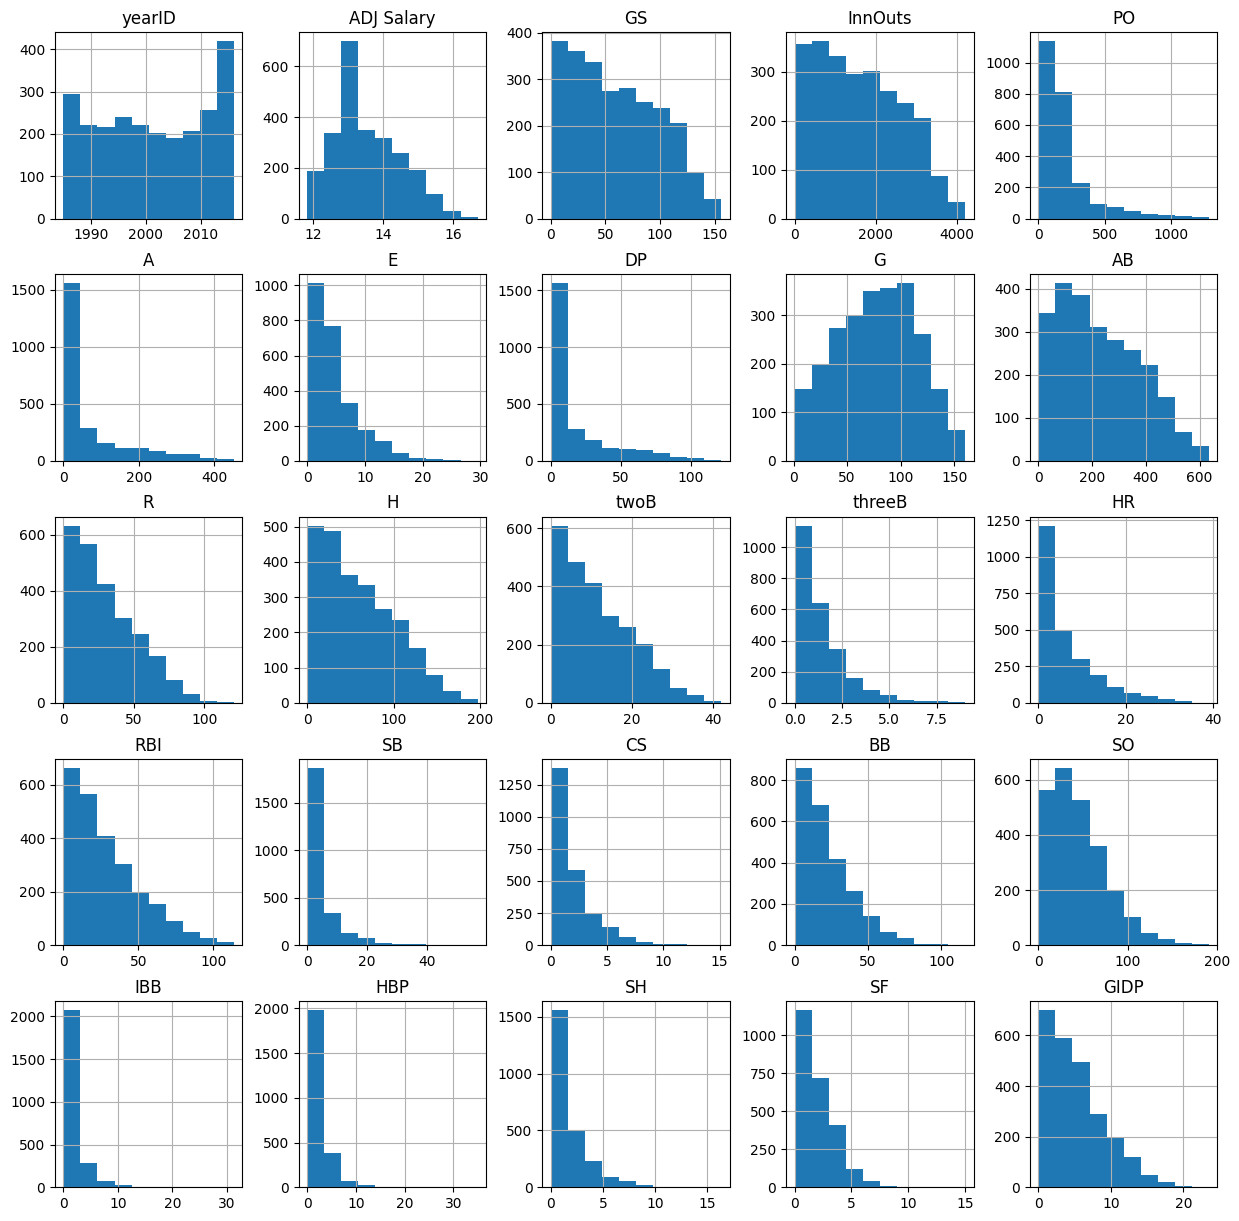

In [47]:
# Look at distributions of the variables

agg_df.hist(figsize = (15, 15))  

In [48]:
# Correlation matrix reveals the best independent variables: RBI, H, R, 2B

cols = ["ADJ Salary","GS","InnOuts","PO","A","E","DP","G","AB","R",\
        "H","twoB","threeB","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]

corr = agg_df[cols].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr

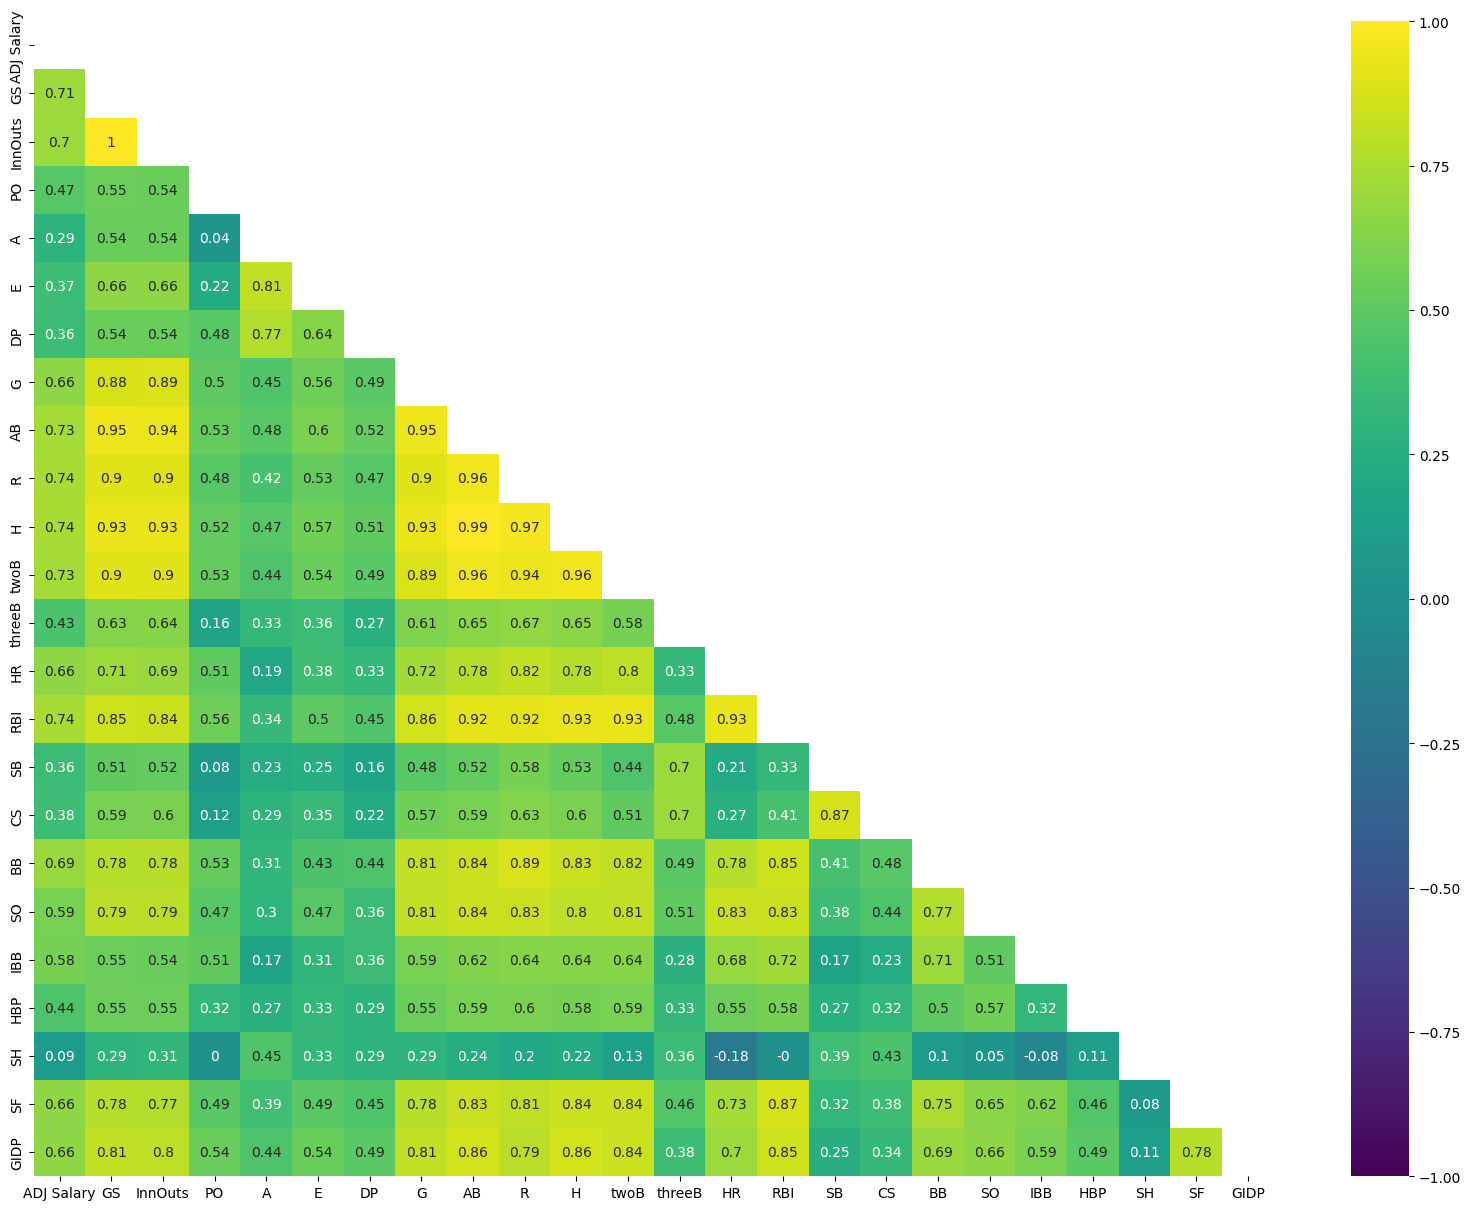

In [49]:
cols = ["ADJ Salary","GS","InnOuts","PO","A","E","DP","G","AB","R",\
        "H","twoB","threeB","HR","RBI","SB","CS","BB","SO","IBB","HBP","SH","SF","GIDP"]

matrix = agg_df[cols].corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='viridis', mask=mask, ax=ax)
plt.savefig("agg_df_correlation_matrix.png")
plt.show()

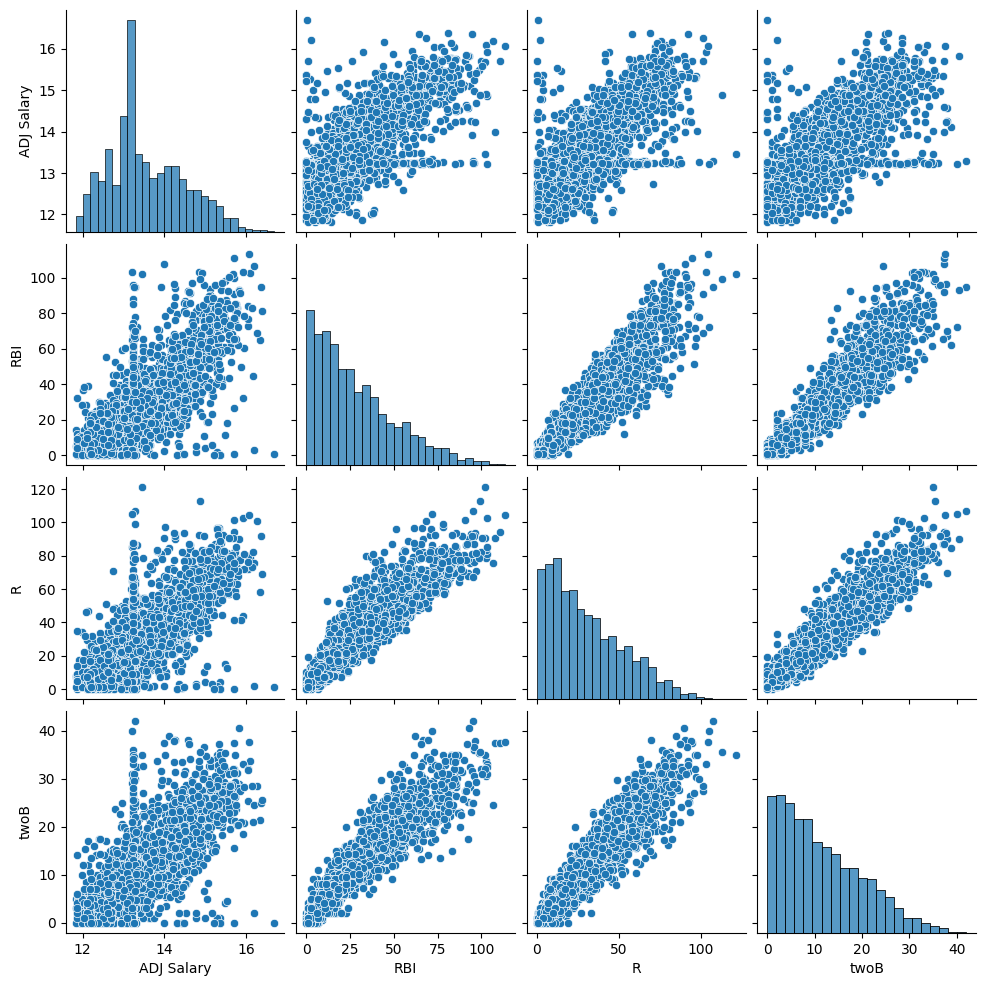

In [50]:
# Looking for multicollinearity

sns.pairplot(agg_df[["ADJ Salary","RBI", "R", "twoB"]])

In [51]:
# Lots of multicollinearity, but all these vars plot a linear relationship with ADJ Salary

corr = agg_df[["ADJ Salary","RBI", "R", "twoB"]].corr()
corr = corr.style.background_gradient(cmap='Purples')
corr

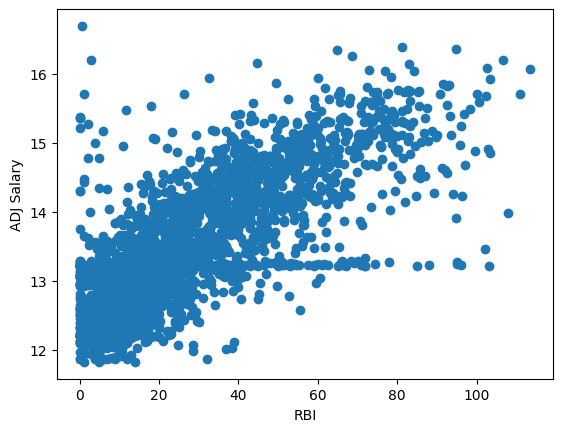

In [52]:
plt.scatter(agg_df["RBI"], agg_df["ADJ Salary"])
plt.xlabel("RBI")
plt.ylabel("ADJ Salary")
plt.show()

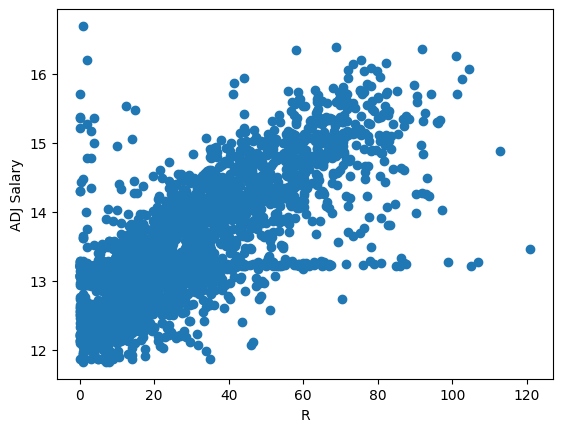

In [53]:
plt.scatter(agg_df["R"], agg_df["ADJ Salary"])
plt.xlabel("R")
plt.ylabel("ADJ Salary")
plt.show()

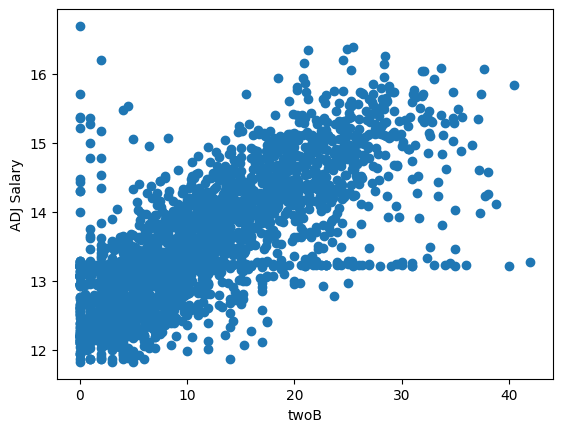

In [54]:
plt.scatter(agg_df["twoB"], agg_df["ADJ Salary"])
plt.xlabel("twoB")
plt.ylabel("ADJ Salary")
plt.show()

In [55]:
simple_LR(agg_df, ["RBI"])

LR1 Training Score: 		0.5587114213767878
LR1 Testing Score: 	0.5263642902641976
LR1 r2: 			-679.1437379316649
LR1 mse: 			584.2684179829893

GBR1 Training Score: 		0.622834520943153
GBR1 Testing Score: 	0.5418880078457078
GBR1 r2: 			-5.2873522631420995
GBR1 mse: 			5.401066208826705

RFR1 Training Score: 		0.7500111442152244
RFR1 Testing Score: 	0.45441374428583636
RFR1 r2: 			-5.047952101611357
RFR1 mse: 			5.195412689075426

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     3021.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:26:08   Log-Likelihood:                -2312.2
No. Observations:                2468   AIC:                             4628.
Df Residuals:  

In [56]:
simple_LR(agg_df, ["R"])

LR1 Training Score: 		0.5440764391321746
LR1 Testing Score: 	0.5360626149052451
LR1 r2: 			-731.7012022540478
LR1 mse: 			629.417207599459

GBR1 Training Score: 		0.6242977013976643
GBR1 Testing Score: 	0.5537341210974667
GBR1 r2: 			-0.13938695675613766
GBR1 mse: 			0.9787751876078375

RFR1 Training Score: 		0.7526623316403319
RFR1 Testing Score: 	0.4719388192451571
RFR1 r2: 			-0.19197673723460507
RFR1 mse: 			1.0239517379877132

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     2919.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:26:09   Log-Likelihood:                -2335.4
No. Observations:                2468   AIC:                             4675.
Df Residual

In [57]:
simple_LR(agg_df, ["twoB"])

LR1 Training Score: 		0.5274799842028941
LR1 Testing Score: 	0.5286500055587495
LR1 r2: 			-95.65359420329844
LR1 mse: 			83.02898259309534

GBR1 Training Score: 		0.6103622623026534
GBR1 Testing Score: 	0.565303501077949
GBR1 r2: 			-0.7387587099977184
GBR1 mse: 			1.4936575080936485

RFR1 Training Score: 		0.7027552606046649
RFR1 Testing Score: 	0.5487891051202691
RFR1 r2: 			-0.7162428811360981
RFR1 mse: 			1.4743155852398704

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     2757.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:26:09   Log-Likelihood:                -2373.1
No. Observations:                2468   AIC:                             4750.
Df Residuals:

## Let's try multivariate linear regression again, this time on the aggregated dataset

In [63]:
agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y

X = agg_df[["RBI","R","twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

LR2 = LinearRegression().fit(X_train_scaled, y_train)
GBR2 = GradientBoostingRegressor().fit(X_train_scaled, y_train)
RFR2 = RandomForestRegressor().fit(X_train_scaled, y_train)

LR2_pred = LR2.predict(X_test)
GBR2_pred = GBR2.predict(X_test)
RFR2_pred = RFR2.predict(X_test)

LR2_mse = mean_squared_error(y_test, LR2_pred)
GBR2_mse = mean_squared_error(y_test, GBR2_pred)
RFR2_mse = mean_squared_error(y_test, RFR2_pred)

LR2_r2 = r2_score(y_test, LR2_pred)
GBR2_r2 = r2_score(y_test, GBR2_pred)
RFR2_r2 = r2_score(y_test, RFR2_pred)

# Score the regression models

print(f"LR2 Training Score: \t\t{LR2.score(X_train_scaled, y_train)}")
print(f"LR2 Testing Score: \t{LR2.score(X_test_scaled, y_test)}")
print(f"LR2 r2: \t\t\t{LR2_r2}")
print(f"LR2 mse: \t\t\t{LR2_mse}\n")

print(f"GBR2 Training Score: \t\t{GBR2.score(X_train_scaled, y_train)}")
print(f"GBR2 Testing Score: \t{GBR2.score(X_test_scaled, y_test)}")
print(f"GBR2 r2: \t\t\t{GBR2_r2}")
print(f"GBR2 mse: \t\t\t{GBR2_mse}\n")

print(f"RFR2 Training Score: \t\t{RFR2.score(X_train_scaled, y_train)}")
print(f"RFR2 Testing Score: \t{RFR2.score(X_test_scaled, y_test)}")
print(f"RFR2 r2: \t\t\t{RFR2_r2}")
print(f"RFR2 mse: \t\t\t{RFR2_mse}\n")

# LR1_stats = smf.ols(formula = 'y ~ yearID + GS + InnOuts + PO + A + E + DP + G + AB + R + H +\
# twoB + threeB + HR + RBI + SB + CS + BB + SO + IBB + HBP + SH + SF + GIDP', data=X).fit()

LR2_stats = smf.ols(formula = "y ~ RBI + R + twoB", data=X).fit()
                    
LR2_stats.summary()

LR2 Training Score: 		0.5729109548748015
LR2 Testing Score: 	0.555100882165029
LR2 r2: 			-687.7867995207109
LR2 mse: 			591.6931249082022

GBR2 Training Score: 		0.678312512329801
GBR2 Testing Score: 	0.5923087318424451
GBR2 r2: 			-0.6128723276256589
GBR2 mse: 			1.3855164882295288

RFR2 Training Score: 		0.9068195123442202
RFR2 Testing Score: 	0.534771668112384
RFR2 r2: 			-0.6099766251248364
RFR2 mse: 			1.3830289735693924



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1083.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:44:00   Log-Likelihood:                -2261.5
No. Observations:                2468   AIC:                             4531.
Df Residuals:                    2464   BIC:                             4554.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6500      0.020    617.843      0.000      12.610      12.690
RBI            0.0158      0.002      9.977      0.000       0.013       0.019
R              0.0123      0.002      7.062      0.000       0.009       0.016
twoB           0.0080      0.005      1.642      0.101      -0.002       0.017
==============================================================================
Omnibus:                      185.073   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.666
Skew:                           0.245   Prob(JB):                    4.49e-168
Kurtosis:                       5.694   Cond. No.                         90.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

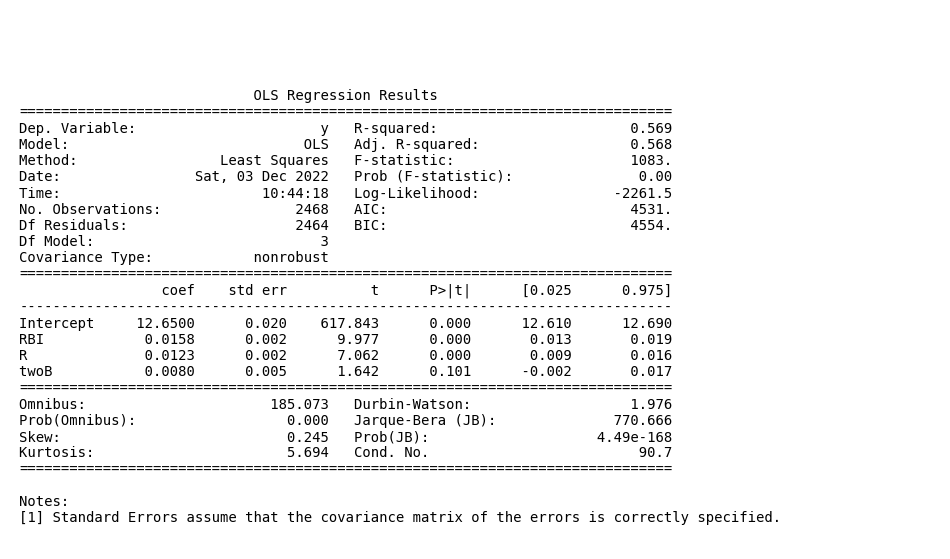

In [64]:
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(LR2_stats.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.savefig('LR2_stats_summary.png')

## Results: 
- the linear regressions on the aggregated data now explain nearly 60% of variance!

# Linear Regression Ensemble Methods

In [60]:
# LinearRegression()

agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y

X = agg_df[["H","R","GS"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression().fit(X_train_scaled, y_train)

# Score the model

print(f"STDSCALER Linear Regression Score: {model.score(X_train_scaled, y_train)}")
print(f"STDSCALER Linear Regression Score: {model.score(X_test_scaled, y_test)}")

STDSCALER Linear Regression Score: 0.5568103360730356
STDSCALER Linear Regression Score: 0.5579799317051095


MSE: 1.6580410264201149
R2: -0.9301166837778043
Ridge Regression Score: -0.9122646005875643
Ridge Regression Score: -0.9301166837778043


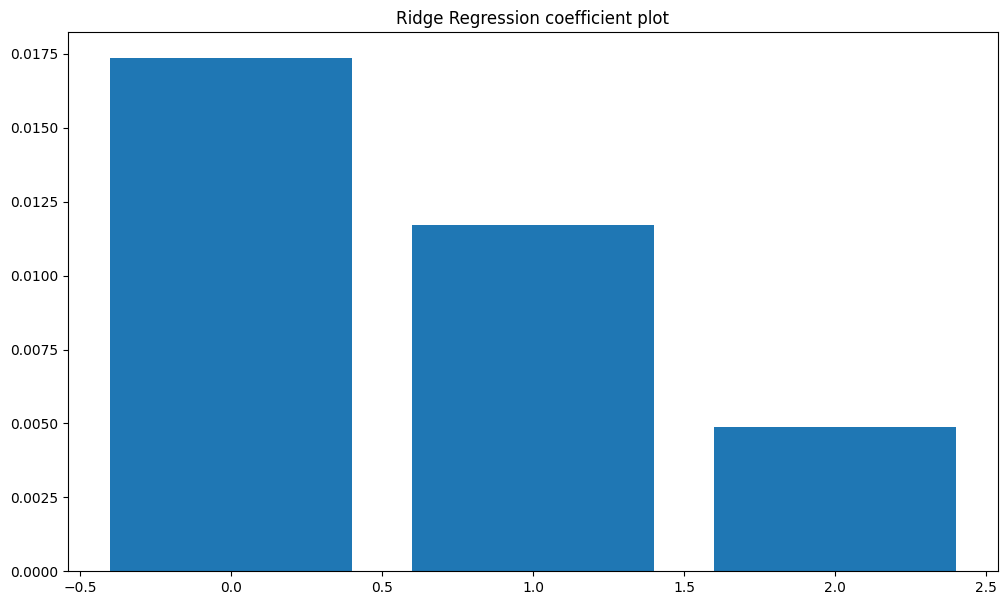

New ridge regression score: 0.5808081075750928


In [61]:
agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y

X = agg_df[["RBI","R","twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_reg = Ridge().fit(X_train, y_train)

predicted = ridge_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"MSE: {mse}")
print(f"R2: {r2}") 

# Score the model

print(f"Ridge Regression Score: {ridge_reg.score(X_train_scaled, y_train)}")
print(f"Ridge Regression Score: {ridge_reg.score(X_test_scaled, y_test)}")

plt.bar(np.arange(len(ridge_reg.coef_)), ridge_reg.coef_)
plt.title(f'Ridge Regression coefficient plot')
plt.show()     

sel = SelectFromModel(ridge_reg)
sel.fit(X_train_scaled, y_train)
SelectFromModel(estimator=Ridge())

X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

new_ridge_reg = LinearRegression().fit(X_selected_train_scaled, y_train)
print(f"New ridge regression score: {new_ridge_reg.score(X_selected_test_scaled, y_test)}")

MSE: 1.6051428397291518
R2: -0.868538187801583
ElasticNet Regression Score: -0.8509201166446692
ElasticNet Regression Score: -0.868538187801583


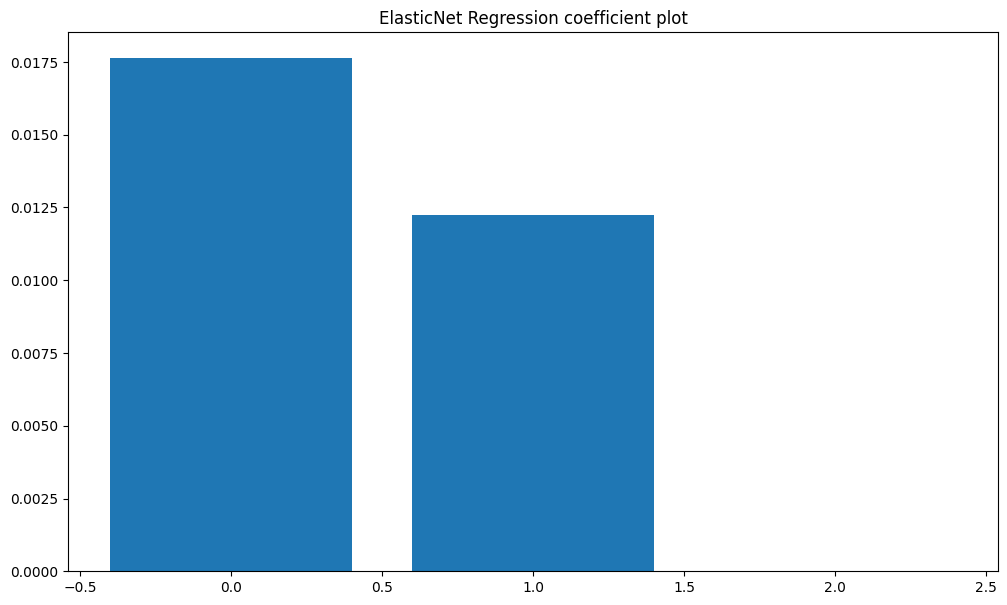

New linear regression score: 0.5808081075750928


In [62]:
agg_df = pd.read_csv("second_predictions_df.csv", index_col="playerID")
agg_df

# Assign X and y


X = agg_df[["RBI","R","twoB"]]

y = agg_df["ADJ Salary"]

# Split the data into X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Create a scaler to standardize the data

scaler = StandardScaler()

# Train the scaler with the X_train data.

scaler.fit(X_train)

# Transform X_train and X_test.

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

elasticnet_reg = ElasticNet().fit(X_train, y_train)

predicted = elasticnet_reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"MSE: {mse}")
print(f"R2: {r2}") 

# Score the model

print(f"ElasticNet Regression Score: {elasticnet_reg.score(X_train_scaled, y_train)}")
print(f"ElasticNet Regression Score: {elasticnet_reg.score(X_test_scaled, y_test)}")

plt.bar(np.arange(len(elasticnet_reg.coef_)), elasticnet_reg.coef_)
plt.title(f'ElasticNet Regression coefficient plot')
plt.show()  

sel = SelectFromModel(elasticnet_reg)
sel.fit(X_train_scaled, y_train)
SelectFromModel(estimator=ElasticNet())

X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)

scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

new_elasticnet_reg = LinearRegression().fit(X_selected_train_scaled, y_train)
print(f"New linear regression score: {new_elasticnet_reg.score(X_selected_test_scaled, y_test)}")